# Face Generation GAN

In [1]:
%matplotlib inline

import os
import math
import hashlib
import zipfile
import gzip
import shutil
import warnings

from urllib.request import urlretrieve
from distutils.version import LooseVersion
from PIL import Image
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot

import numpy as np
import tensorflow as tf

## Downloading and Extracting Data

In [2]:
class DataExtractor:
    
    def download_extract(self, database_name, data_path):
        """
        Download and extract database.
        
        :param database_name: Database name
        :param data_path: Data save directory
        """
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'

        if database_name == DATASET_CELEBA_NAME:
            url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
            hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
            extract_path = os.path.join(data_path, 'img_align_celeba')
            save_path = os.path.join(data_path, 'celeba.zip')
            extract_fn = self.unzip
        elif database_name == DATASET_MNIST_NAME:
            url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
            hash_code = 'f68b3c2dcbeaaa9fbdd348bbdeb94873'
            extract_path = os.path.join(data_path, 'mnist')
            save_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
            extract_fn = self.ungzip

        if os.path.exists(extract_path):
            print('Found {} Data'.format(database_name))
            return

        if not os.path.exists(data_path):
            os.makedirs(data_path)

        if not os.path.exists(save_path):
            with DLProgress(unit='B', unit_scale=True, miniters=1, 
                            desc='Downloading {}'.format(database_name)) as pbar:
                urlretrieve(url,
                            save_path,
                            pbar.hook)

        assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
            '{} file is corrupted.  Remove the file and try again.'.format(save_path)

        os.makedirs(extract_path)
        
        try:
            extract_fn(save_path, extract_path, database_name, data_path)
        except Exception as err:
            shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
            raise err

        # Remove compressed data
        os.remove(save_path)
    
    
    def unzip(self, save_path, _, database_name, data_path):
        """
        Unzip wrapper with the same interface as _ungzip.
        
        :param save_path: The path of the gzip files
        :param database_name: Name of database
        :param data_path: Path to extract to
        :param _: HACK - Used to have to same interface as _ungzip
        """
        print('Extracting {}...'.format(database_name))
        with zipfile.ZipFile(save_path) as zf:
            zf.extractall(data_path)


    def ungzip(self, save_path, extract_path, database_name, _):
        """
        Unzip a gzip file and extract it to extract_path.
        
        :param save_path: The path of the gzip files
        :param extract_path: The location to extract the data to
        :param database_name: Name of database
        :param _: HACK - Used to have to same interface as _unzip
        """
        # Get data from save_path
        with open(save_path, 'rb') as f:
            with gzip.GzipFile(fileobj=f) as bytestream:
                magic = self.read32(bytestream)
                if magic != 2051:
                    raise ValueError('Invalid magic number {} in file: {}'\
                                     .format(magic, f.name))
                num_images = self.read32(bytestream)
                rows = self.read32(bytestream)
                cols = self.read32(bytestream)
                buf = bytestream.read(rows * cols * num_images)
                data = np.frombuffer(buf, dtype=np.uint8)
                data = data.reshape(num_images, rows, cols)

        # Save data to extract_path
        for image_i, image in enumerate(
                tqdm(data, unit='File', unit_scale=True, miniters=1, 
                     desc='Extracting {}'.format(database_name))):
            Image.fromarray(image, 'L').save(
                os.path.join(extract_path, 'image_{}.jpg'.format(image_i)))
            
            
    def read32(self, bytestream):
        """
        Read 32-bit integer from bytesteam.
        
        :param bytestream: A bytestream
        :return: 32-bit integer
        """
        dt = np.dtype(np.uint32).newbyteorder('>')
        return np.frombuffer(bytestream.read(4), dtype=dt)[0]    

In [3]:
class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers 
                            which do not return a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [4]:
# data_dir = './data'
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe' # FloydHub

In [5]:
dataExtractor = DataExtractor()

dataExtractor.download_extract('mnist', data_dir)
dataExtractor.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Exploring Image Data

In [6]:
class Dataset(object):
    """
    Dataset
    """
    def __init__(self, dataset_name, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        DATASET_CELEBA_NAME = 'celeba'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28

        if dataset_name == DATASET_CELEBA_NAME:
            self.image_mode = 'RGB'
            image_channels = 3

        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels
        
        
    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = DataBatchGenerator().get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

In [7]:
class DataBatchGenerator:
    
    def get_batch(self, image_files, width, height, mode):
        """
        Generate image data batch.
        """
        data_batch = np.array(
            [self.get_image(sample_file, width, height, mode) \
                 for sample_file in image_files]).astype(np.float32)

        # Make sure the images are in 4 dimensions
        if len(data_batch.shape) < 4:
            data_batch = data_batch.reshape(data_batch.shape + (1,))

        return data_batch
    
    
    def get_image(self, image_path, width, height, mode):
        """
        Read image from image_path.
        
        :param image_path: Path of image
        :param width: Width of image
        :param height: Height of image
        :param mode: Mode of image
        :return: Image data
        """
        image = Image.open(image_path)

        # HACK - Check if image is from the CELEBA dataset
        if image.size != (width, height):  
            # Remove most pixels that aren't part of a face
            face_width = face_height = 108
            j = (image.size[0] - face_width) // 2
            i = (image.size[1] - face_height) // 2
            image = image.crop([j, i, j + face_width, i + face_height])
            image = image.resize([width, height], Image.BILINEAR)

        return np.array(image.convert(mode))

In [8]:
class ImageDisplayer:
    
    def images_square_grid(self, images, mode):
        """
        Save images as a square grid.
        
        :param images: Images to be used for the grid
        :param mode: The mode to use for images
        :return: Image of images in a square grid
        """
        # Get maximum size for square grid of images
        save_size = math.floor(np.sqrt(images.shape[0]))

        # Scale to 0-255
        images = (((images-images.min())*255)/(images.max()-images.min())).astype(np.uint8)

        # Put images in a square arrangement
        images_in_square = np.reshape(
                images[:save_size*save_size],
                (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
        if mode == 'L':
            images_in_square = np.squeeze(images_in_square, 4)

        # Combine images to grid image
        new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
        for col_i, col_images in enumerate(images_in_square):
            for image_i, image in enumerate(col_images):
                im = Image.fromarray(image, mode)
                new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

        return new_im

In [9]:
show_n_images = 25

In [10]:
dataBatchGenerator = DataBatchGenerator()
imageDisplayer = ImageDisplayer()

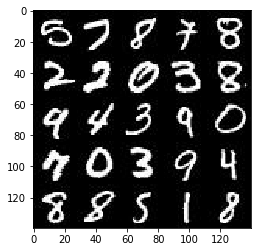

In [11]:
mnist_images = dataBatchGenerator.get_batch(
    glob(os.path.join(data_dir, 'mnist/*.jpg'))\
        [:show_n_images], 28, 28, 'L')

pyplot.imshow(imageDisplayer.images_square_grid(mnist_images, 'L'), cmap='gray')

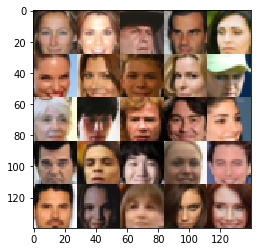

In [12]:
celeba_images = dataBatchGenerator.get_batch(
    glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))\
        [:show_n_images], 28, 28, 'RGB')

pyplot.imshow(imageDisplayer.images_square_grid(celeba_images, 'RGB'))

## Checking TensorFlow/GPU

In [13]:
class TensorFlowGPUChecker:
    
    def check(self):
        # Check TensorFlow Version
        assert LooseVersion(tf.__version__) >= LooseVersion('1.0'),\
            'Please use TensorFlow version 1.0 or newer.  You are using {}'.\
            format(tf.__version__)
        print('TensorFlow Version: {}'.format(tf.__version__))

        # Check for a GPU
        if not tf.test.gpu_device_name():
            warnings.warn('No GPU found. Please use a GPU to train your neural network.')
        else:
            print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

In [14]:
tfgChecker = TensorFlowGPUChecker()

tfgChecker.check()

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


## Building and Training GAN

In [15]:
class GAN:
    
    def __init__(self, input_real, input_z, lr, d_loss, g_loss, d_opt, g_opt):
        self.input_real = input_real
        self.input_z = input_z
        self.lr = lr
        self.d_loss = d_loss
        self.g_loss = g_loss
        self.d_opt = d_opt
        self.g_opt = g_opt

In [16]:
class GANBuilder:
    
    def build_gan(self, data_shape, alpha, beta1, dropout):
        """
        Build GAN.
        
        :param data_shape: Input data shape
        :param alpha: Factor for Leaky ReLU
        :param beta_1: The exponential decay rate for the 1st moment in the optimizer
        :param dropout: Dropout rate
        :return: GAN object built
        """        
        input_real, input_z, lr = self.model_inputs(data_shape[1], 
                                                    data_shape[2], 
                                                    data_shape[3], 
                                                    z_dim)
        d_loss, g_loss = self.model_loss(input_real, input_z, data_shape[3], alpha, dropout)
        d_opt, g_opt = self.model_opt(d_loss, g_loss, lr, beta1)

        return GAN(input_real, input_z, lr, d_loss, g_loss, d_opt, g_opt)
    
    
    def model_inputs(self, image_width, image_height, image_channels, z_dim):
        """
        Create the model inputs.
        
        :param image_width: The input image width
        :param image_height: The input image height
        :param image_channels: The number of image channels
        :param z_dim: The dimension of Z
        :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
        """

        image_shape = (image_width, image_height, image_channels)
        input_real = tf.placeholder(tf.float32, (None, *image_shape), name='input_real')
        input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
        lr = tf.placeholder(tf.float32, name='learning_rate')

        return (input_real, input_z, lr)

    
    def discriminator(self, images, alpha, dropout, reuse=False):
        """
        Create the discriminator network.
        
        :param images: Tensor of input image(s)
        :param alpha: Factor for Leaky ReLU
        :param dropout: Dropout rate
        :param reuse: Boolean if the weights should be reused
        :return: Tuple of (tensor output of the discriminator, 
                           tensor logits of the discriminator)
        """
        
        def conv2d(x, out_dim, k=5, s=2, padding='same', use_batch_norm=True, training=True):
            initializer = tf.contrib.layers.xavier_initializer_conv2d()
            layer = tf.layers.conv2d(x, out_dim, k, s, padding, 
                                     kernel_initializer=initializer)
            if use_batch_norm == True:
                layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.layers.dropout(layer, rate=dropout)
            layer = tf.maximum(alpha*layer, layer)
            return layer

        with tf.variable_scope('discriminator', reuse=reuse):
            layer_1 = conv2d(images,   32, use_batch_norm=False, training=False) # => 14x14x32                       
            layer_2 = conv2d(layer_1,  64) # => 7x7x64
            layer_3 = conv2d(layer_2, 128) # => 4x4x128 
            layer_4 = conv2d(layer_3, 256) # => 2x2x256

            flat = tf.reshape(layer_4, (-1, 2*2*256))

            logits = tf.layers.dense(flat, 1)
            output = tf.sigmoid(logits)

            return output, logits
    
    
    def generator(self, z, out_channel_dim, alpha, dropout, is_train=True):
        """
        Create the generator network.
        
        :param z: Input z
        :param out_channel_dim: The number of channels in the output image
        :param alpha: Factor for Leaky RELU
        :param dropout: Dropout rate
        :param is_train: Boolean if generator is being used for training
        :return: The tensor output of the generator
        """
        
        def fully_connect(x, dims, training):
            layer = tf.layers.dense(x, dims[0]*dims[1]*dims[2])
            layer = tf.reshape(layer, (-1, dims[0], dims[1], dims[2]))
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.layers.dropout(layer, rate=dropout)
            layer = tf.maximum(alpha*layer, layer)
            return layer

        def conv2d_transpose(x, out_dim, k=5, s=2, padding='same', 
                             use_batch_norm=True, use_leaky_relu=True, training=True):
            
            initializer = tf.contrib.layers.xavier_initializer_conv2d()
            layer = tf.layers.conv2d_transpose(x, out_dim, k, s, padding,
                                               kernel_initializer=initializer)
            if use_batch_norm == True:
                layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.layers.dropout(layer, rate=dropout)
            if use_leaky_relu == True:
                layer = tf.maximum(alpha*layer, layer)
                
            return layer
        
        with tf.variable_scope('generator', reuse=not is_train):
            layer_1 = fully_connect(z, (4, 4, 512), is_train)           # => 4x4x512
            layer_2 = conv2d_transpose(layer_1, 128, k=4, s=1, 
                                       padding='valid',
                                       training=is_train)               # => 7x7x128  
            layer_3 = conv2d_transpose(layer_2, 64, training=is_train)  # => 14x14x64
            layer_4 = conv2d_transpose(layer_3, 32, training=is_train)  # => 28x28x32 

            logits = conv2d_transpose(layer_4, out_channel_dim, 3, 1, 
                                      'same', False, False, True)       # => 28x28x3(1)
            
            output = tf.tanh(logits)

            return output
    
    
    def model_loss(self, input_real, input_z, out_channel_dim, alpha, dropout):
        """
        Get the loss for the discriminator and generator.
        
        :param input_real: Images from the real dataset
        :param input_z: Z input
        :param out_channel_dim: The number of channels in the output image
        :param alpha: Factor for Leaky RELU
        :param dropout: Dropout rate
        :return: A tuple of (discriminator loss, generator loss)
        """

        g_model = self.generator(
            input_z, out_channel_dim, alpha, dropout, is_train=True)
        d_model_real, d_logits_real = self.discriminator(
            input_real, alpha, dropout, reuse=False)
        d_model_fake, d_logits_fake = self.discriminator(
            g_model, alpha, dropout, reuse=True)

        def get_loss(logits, labels):
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, 
                                                                          labels=labels))

        d_loss_real = get_loss(d_logits_real, tf.ones_like(d_model_real))
        d_loss_fake = get_loss(d_logits_fake, tf.zeros_like(d_model_fake))
        g_loss = get_loss(d_logits_fake, tf.ones_like(d_model_fake))

        d_loss = d_loss_real + d_loss_fake

        return (d_loss, g_loss)
    
    
    def model_opt(self, d_loss, g_loss, learning_rate, beta1):
        """
        Get optimization operations.
        
        :param d_loss: Discriminator loss Tensor
        :param g_loss: Generator loss Tensor
        :param learning_rate: Learning Rate Placeholder
        :param beta1: The exponential decay rate for the 1st moment in the optimizer
        :return: A tuple of (discriminator training operation, 
                             generator training operation)
        """

        # Get weights and bias to update
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                            .minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1)\
                            .minimize(g_loss, var_list=g_vars)    

        return (d_train_opt, g_train_opt)

In [17]:
class GANTrainer:
    
    def train_gan(self, epoch_count, batch_size, z_dim, learning_rate, alpha, beta1, dropout,
                  get_batches, data_shape, data_image_mode):
        """
        Train the GAN.
        
        :param epoch_count: Number of epochs
        :param batch_size: Batch Size
        :param z_dim: Z dimension
        :param learning_rate: Learning Rate
        :param alpha: Factor for Leaky ReLU
        :param beta1: The exponential decay rate for the 1st moment in the optimizer
        :param dropout: Dropout rate
        :param get_batches: Function to get batches
        :param data_shape: Shape of the data
        :param data_image_mode: The image mode to use for images ("RGB" or "L")
        """

        gan = GANBuilder().build_gan(data_shape, alpha, beta1, dropout)
        
        step = 0
        print_every = 10
        show_every = 100
        n_images_to_show = 25

        d_losses, g_losses = [], []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_i in range(epoch_count):          
                for batch_images in get_batches(batch_size):
                    batch_images *= 2
                    step += 1

                    # Sample random noise for G
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    # Run optimizers
                    _ = sess.run(gan.d_opt, feed_dict={gan.input_real: batch_images,
                                                       gan.input_z: batch_z,
                                                       gan.lr: learning_rate})
                    _ = sess.run(gan.g_opt, feed_dict={gan.input_real: batch_images,
                                                       gan.input_z: batch_z,
                                                       gan.lr: learning_rate})

                    if step % print_every == 0:
                        train_loss_d = gan.d_loss.eval({gan.input_real: batch_images,
                                                        gan.input_z: batch_z})
                        train_loss_g = gan.g_loss.eval({gan.input_z: batch_z})
                        
                        self.print_losses(epoch_count, epoch_i, step,
                                          train_loss_d, train_loss_g, 
                                          d_losses, g_losses)

                    if step % show_every == 0:
                        self.print_cumulative_average_losses(train_loss_d, train_loss_g, 
                                                             d_losses, g_losses)

                        self.show_generator_output(sess, n_images_to_show, gan.input_z, 
                                                   data_shape[3], alpha, dropout, data_image_mode)
                        
    
    def print_losses(self, epochs, epoch_i, step, 
                     train_loss_d, train_loss_g, d_losses, g_losses):
        
        d_losses.append(train_loss_d)
        g_losses.append(train_loss_g)

        print("Epoch {}/{}...".format(epoch_i+1, epochs),
              "Step: {}...".format(step),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
    
    def print_cumulative_average_losses(self, train_loss_d, train_loss_g, d_losses, g_losses):
        cum_avg_d_loss = np.mean(d_losses)
        cum_avg_g_loss = np.mean(g_losses)

        print("Cumulative Average Generator Loss / Discriminator Loss: {}".format(
            cum_avg_g_loss / cum_avg_d_loss))
        print("Current Generator Loss / Discriminator Loss: {}".format(
            train_loss_g / train_loss_d))
        
    def show_generator_output(self, sess, n_images, input_z, out_dim, alpha, dropout, image_mode):
        """
        Show example output for the generator.
        
        :param sess: TensorFlow session
        :param n_images: Number of Images to display
        :param input_z: Input Z Tensor
        :param out_dim: The number of channels in the output image
        :param image_mode: The mode to use for images ("RGB" or "L")
        """
        cmap = None if image_mode == 'RGB' else 'gray'
        z_dim = input_z.get_shape().as_list()[-1]
        example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

        samples = sess.run(
            GANBuilder().generator(input_z, out_dim, alpha, dropout, False),
                                   feed_dict={input_z: example_z})

        images_grid = ImageDisplayer().images_square_grid(samples, image_mode)
        
        pyplot.imshow(images_grid, cmap=cmap)
        pyplot.show()

## Training Model on MNIST Dataset

Epoch 1/2... Step: 10... Discriminator Loss: 0.7619... Generator Loss: 2.6147
Epoch 1/2... Step: 20... Discriminator Loss: 2.8454... Generator Loss: 0.0714
Epoch 1/2... Step: 30... Discriminator Loss: 2.6144... Generator Loss: 0.0955
Epoch 1/2... Step: 40... Discriminator Loss: 1.2165... Generator Loss: 0.4741
Epoch 1/2... Step: 50... Discriminator Loss: 1.4788... Generator Loss: 0.3234
Epoch 1/2... Step: 60... Discriminator Loss: 0.5672... Generator Loss: 2.3046
Epoch 1/2... Step: 70... Discriminator Loss: 2.2353... Generator Loss: 0.1342
Epoch 1/2... Step: 80... Discriminator Loss: 1.1822... Generator Loss: 0.5617
Epoch 1/2... Step: 90... Discriminator Loss: 1.2263... Generator Loss: 1.4664
Epoch 1/2... Step: 100... Discriminator Loss: 1.5865... Generator Loss: 0.3039
Cumulative Average Generator Loss / Discriminator Loss: 0.5313442349433899
Current Generator Loss / Discriminator Loss: 0.19152970612049103


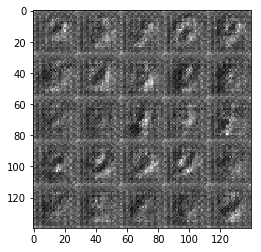

Epoch 1/2... Step: 110... Discriminator Loss: 1.2543... Generator Loss: 0.5056
Epoch 1/2... Step: 120... Discriminator Loss: 1.3500... Generator Loss: 0.4557
Epoch 1/2... Step: 130... Discriminator Loss: 1.6184... Generator Loss: 0.3304
Epoch 1/2... Step: 140... Discriminator Loss: 1.0585... Generator Loss: 0.8862
Epoch 1/2... Step: 150... Discriminator Loss: 1.0279... Generator Loss: 1.0490
Epoch 1/2... Step: 160... Discriminator Loss: 0.8606... Generator Loss: 1.0778
Epoch 1/2... Step: 170... Discriminator Loss: 1.8325... Generator Loss: 0.1990
Epoch 1/2... Step: 180... Discriminator Loss: 1.2121... Generator Loss: 0.5232
Epoch 1/2... Step: 190... Discriminator Loss: 1.1435... Generator Loss: 0.5419
Epoch 1/2... Step: 200... Discriminator Loss: 0.9774... Generator Loss: 0.7560
Cumulative Average Generator Loss / Discriminator Loss: 0.5231674909591675
Current Generator Loss / Discriminator Loss: 0.7734851837158203


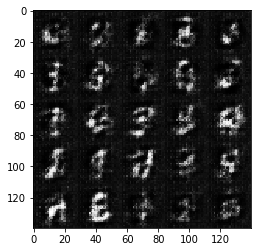

Epoch 1/2... Step: 210... Discriminator Loss: 0.9291... Generator Loss: 0.8178
Epoch 1/2... Step: 220... Discriminator Loss: 1.1120... Generator Loss: 0.5764
Epoch 1/2... Step: 230... Discriminator Loss: 1.0203... Generator Loss: 0.6669
Epoch 1/2... Step: 240... Discriminator Loss: 0.9047... Generator Loss: 1.2975
Epoch 1/2... Step: 250... Discriminator Loss: 1.5059... Generator Loss: 0.3630
Epoch 1/2... Step: 260... Discriminator Loss: 1.4772... Generator Loss: 0.3134
Epoch 1/2... Step: 270... Discriminator Loss: 0.7154... Generator Loss: 1.8075
Epoch 1/2... Step: 280... Discriminator Loss: 1.0170... Generator Loss: 0.6195
Epoch 1/2... Step: 290... Discriminator Loss: 1.0083... Generator Loss: 0.6514
Epoch 1/2... Step: 300... Discriminator Loss: 1.4203... Generator Loss: 2.0574
Cumulative Average Generator Loss / Discriminator Loss: 0.6089231371879578
Current Generator Loss / Discriminator Loss: 1.448488473892212


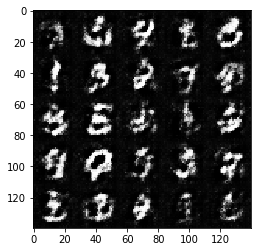

Epoch 1/2... Step: 310... Discriminator Loss: 1.0713... Generator Loss: 1.3585
Epoch 1/2... Step: 320... Discriminator Loss: 1.2282... Generator Loss: 0.7507
Epoch 1/2... Step: 330... Discriminator Loss: 1.4218... Generator Loss: 0.3722
Epoch 1/2... Step: 340... Discriminator Loss: 1.2333... Generator Loss: 0.4794
Epoch 1/2... Step: 350... Discriminator Loss: 1.2883... Generator Loss: 0.9289
Epoch 1/2... Step: 360... Discriminator Loss: 1.7594... Generator Loss: 0.2254
Epoch 1/2... Step: 370... Discriminator Loss: 1.8915... Generator Loss: 0.1978
Epoch 1/2... Step: 380... Discriminator Loss: 1.7529... Generator Loss: 0.2408
Epoch 1/2... Step: 390... Discriminator Loss: 1.0560... Generator Loss: 1.0186
Epoch 1/2... Step: 400... Discriminator Loss: 1.4822... Generator Loss: 0.3202
Cumulative Average Generator Loss / Discriminator Loss: 0.5574625730514526
Current Generator Loss / Discriminator Loss: 0.21601668000221252


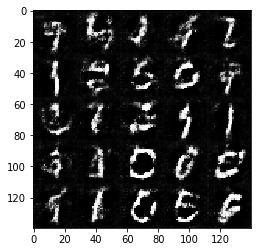

Epoch 1/2... Step: 410... Discriminator Loss: 1.5078... Generator Loss: 0.3702
Epoch 1/2... Step: 420... Discriminator Loss: 1.3930... Generator Loss: 0.3579
Epoch 1/2... Step: 430... Discriminator Loss: 1.8379... Generator Loss: 0.2176
Epoch 1/2... Step: 440... Discriminator Loss: 1.1568... Generator Loss: 0.6330
Epoch 1/2... Step: 450... Discriminator Loss: 1.0545... Generator Loss: 0.9579
Epoch 1/2... Step: 460... Discriminator Loss: 0.8101... Generator Loss: 1.1810
Epoch 1/2... Step: 470... Discriminator Loss: 1.2842... Generator Loss: 1.1579
Epoch 1/2... Step: 480... Discriminator Loss: 1.5136... Generator Loss: 0.3102
Epoch 1/2... Step: 490... Discriminator Loss: 1.0727... Generator Loss: 0.6003
Epoch 1/2... Step: 500... Discriminator Loss: 1.6422... Generator Loss: 0.2518
Cumulative Average Generator Loss / Discriminator Loss: 0.5370293855667114
Current Generator Loss / Discriminator Loss: 0.15334013104438782


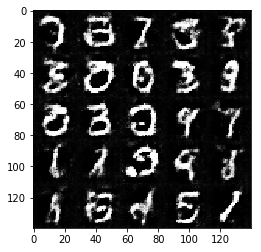

Epoch 1/2... Step: 510... Discriminator Loss: 1.0867... Generator Loss: 0.6638
Epoch 1/2... Step: 520... Discriminator Loss: 1.1908... Generator Loss: 1.4850
Epoch 1/2... Step: 530... Discriminator Loss: 1.8725... Generator Loss: 0.2106
Epoch 1/2... Step: 540... Discriminator Loss: 1.2088... Generator Loss: 0.5063
Epoch 1/2... Step: 550... Discriminator Loss: 1.0769... Generator Loss: 0.6193
Epoch 1/2... Step: 560... Discriminator Loss: 1.2421... Generator Loss: 0.4373
Epoch 1/2... Step: 570... Discriminator Loss: 1.0785... Generator Loss: 0.6216
Epoch 1/2... Step: 580... Discriminator Loss: 1.1779... Generator Loss: 0.5329
Epoch 1/2... Step: 590... Discriminator Loss: 1.4121... Generator Loss: 2.0531
Epoch 1/2... Step: 600... Discriminator Loss: 0.8700... Generator Loss: 0.8187
Cumulative Average Generator Loss / Discriminator Loss: 0.5546391606330872
Current Generator Loss / Discriminator Loss: 0.9410146474838257


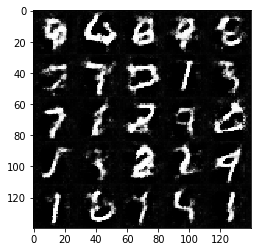

Epoch 1/2... Step: 610... Discriminator Loss: 0.9250... Generator Loss: 0.7523
Epoch 1/2... Step: 620... Discriminator Loss: 0.9251... Generator Loss: 1.0578
Epoch 1/2... Step: 630... Discriminator Loss: 2.2640... Generator Loss: 0.1386
Epoch 1/2... Step: 640... Discriminator Loss: 0.8996... Generator Loss: 1.6630
Epoch 1/2... Step: 650... Discriminator Loss: 1.0240... Generator Loss: 0.6084
Epoch 1/2... Step: 660... Discriminator Loss: 1.3572... Generator Loss: 2.9577
Epoch 1/2... Step: 670... Discriminator Loss: 1.0638... Generator Loss: 0.5867
Epoch 1/2... Step: 680... Discriminator Loss: 1.5618... Generator Loss: 0.2829
Epoch 1/2... Step: 690... Discriminator Loss: 1.6554... Generator Loss: 0.2727
Epoch 1/2... Step: 700... Discriminator Loss: 1.5986... Generator Loss: 0.2820
Cumulative Average Generator Loss / Discriminator Loss: 0.5680968165397644
Current Generator Loss / Discriminator Loss: 0.17638002336025238


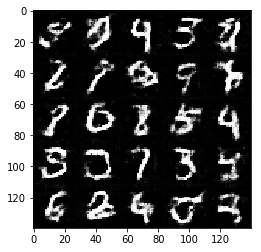

Epoch 1/2... Step: 710... Discriminator Loss: 1.0204... Generator Loss: 0.6689
Epoch 1/2... Step: 720... Discriminator Loss: 1.2367... Generator Loss: 0.4705
Epoch 1/2... Step: 730... Discriminator Loss: 1.2368... Generator Loss: 0.4465
Epoch 1/2... Step: 740... Discriminator Loss: 1.7495... Generator Loss: 0.2396
Epoch 1/2... Step: 750... Discriminator Loss: 0.8592... Generator Loss: 0.9891
Epoch 1/2... Step: 760... Discriminator Loss: 0.9119... Generator Loss: 1.1337
Epoch 1/2... Step: 770... Discriminator Loss: 0.7743... Generator Loss: 1.6154
Epoch 1/2... Step: 780... Discriminator Loss: 1.0628... Generator Loss: 1.0921
Epoch 1/2... Step: 790... Discriminator Loss: 0.8345... Generator Loss: 1.5122
Epoch 1/2... Step: 800... Discriminator Loss: 0.8183... Generator Loss: 1.0459
Cumulative Average Generator Loss / Discriminator Loss: 0.5997340679168701
Current Generator Loss / Discriminator Loss: 1.2781128883361816


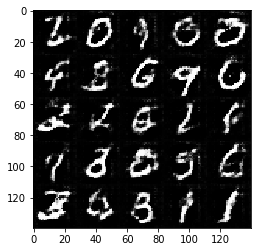

Epoch 1/2... Step: 810... Discriminator Loss: 0.9516... Generator Loss: 1.1136
Epoch 1/2... Step: 820... Discriminator Loss: 0.9329... Generator Loss: 0.6526
Epoch 1/2... Step: 830... Discriminator Loss: 1.0171... Generator Loss: 0.6337
Epoch 1/2... Step: 840... Discriminator Loss: 1.3811... Generator Loss: 2.4123
Epoch 1/2... Step: 850... Discriminator Loss: 1.0543... Generator Loss: 0.5651
Epoch 1/2... Step: 860... Discriminator Loss: 1.7899... Generator Loss: 0.2568
Epoch 1/2... Step: 870... Discriminator Loss: 0.9028... Generator Loss: 1.1621
Epoch 1/2... Step: 880... Discriminator Loss: 1.1173... Generator Loss: 0.5709
Epoch 1/2... Step: 890... Discriminator Loss: 1.6738... Generator Loss: 0.2543
Epoch 1/2... Step: 900... Discriminator Loss: 1.6835... Generator Loss: 0.2498
Cumulative Average Generator Loss / Discriminator Loss: 0.6029645204544067
Current Generator Loss / Discriminator Loss: 0.14838193356990814


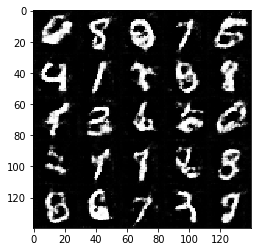

Epoch 1/2... Step: 910... Discriminator Loss: 1.4836... Generator Loss: 0.3265
Epoch 1/2... Step: 920... Discriminator Loss: 1.0712... Generator Loss: 0.6297
Epoch 1/2... Step: 930... Discriminator Loss: 0.9465... Generator Loss: 0.8373
Epoch 1/2... Step: 940... Discriminator Loss: 1.5943... Generator Loss: 0.3178
Epoch 1/2... Step: 950... Discriminator Loss: 1.1062... Generator Loss: 1.9158
Epoch 1/2... Step: 960... Discriminator Loss: 1.6288... Generator Loss: 0.2801
Epoch 1/2... Step: 970... Discriminator Loss: 1.1133... Generator Loss: 0.5797
Epoch 1/2... Step: 980... Discriminator Loss: 0.9900... Generator Loss: 1.7471
Epoch 1/2... Step: 990... Discriminator Loss: 1.0719... Generator Loss: 1.2287
Epoch 1/2... Step: 1000... Discriminator Loss: 1.0941... Generator Loss: 0.5381
Cumulative Average Generator Loss / Discriminator Loss: 0.6116503477096558
Current Generator Loss / Discriminator Loss: 0.4918409287929535


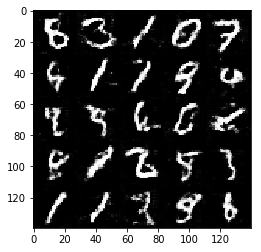

Epoch 1/2... Step: 1010... Discriminator Loss: 1.8485... Generator Loss: 0.2157
Epoch 1/2... Step: 1020... Discriminator Loss: 0.9103... Generator Loss: 0.8786
Epoch 1/2... Step: 1030... Discriminator Loss: 1.4922... Generator Loss: 0.3212
Epoch 1/2... Step: 1040... Discriminator Loss: 1.4175... Generator Loss: 0.3678
Epoch 1/2... Step: 1050... Discriminator Loss: 1.0673... Generator Loss: 0.6248
Epoch 1/2... Step: 1060... Discriminator Loss: 1.3135... Generator Loss: 0.4240
Epoch 1/2... Step: 1070... Discriminator Loss: 2.0403... Generator Loss: 0.1684
Epoch 1/2... Step: 1080... Discriminator Loss: 1.1426... Generator Loss: 2.0399
Epoch 1/2... Step: 1090... Discriminator Loss: 1.4143... Generator Loss: 0.3769
Epoch 1/2... Step: 1100... Discriminator Loss: 1.3347... Generator Loss: 0.4291
Cumulative Average Generator Loss / Discriminator Loss: 0.5924914479255676
Current Generator Loss / Discriminator Loss: 0.3215189576148987


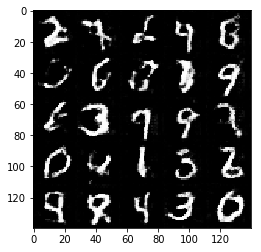

Epoch 1/2... Step: 1110... Discriminator Loss: 0.9773... Generator Loss: 0.5950
Epoch 1/2... Step: 1120... Discriminator Loss: 1.1368... Generator Loss: 0.4780
Epoch 1/2... Step: 1130... Discriminator Loss: 1.3240... Generator Loss: 0.4116
Epoch 1/2... Step: 1140... Discriminator Loss: 1.5005... Generator Loss: 0.3293
Epoch 1/2... Step: 1150... Discriminator Loss: 0.7695... Generator Loss: 1.0745
Epoch 1/2... Step: 1160... Discriminator Loss: 1.5729... Generator Loss: 0.2936
Epoch 1/2... Step: 1170... Discriminator Loss: 1.1217... Generator Loss: 0.5383
Epoch 1/2... Step: 1180... Discriminator Loss: 0.7802... Generator Loss: 2.0315
Epoch 1/2... Step: 1190... Discriminator Loss: 0.8926... Generator Loss: 1.6386
Epoch 1/2... Step: 1200... Discriminator Loss: 1.5924... Generator Loss: 0.2595
Cumulative Average Generator Loss / Discriminator Loss: 0.5973111987113953
Current Generator Loss / Discriminator Loss: 0.16294920444488525


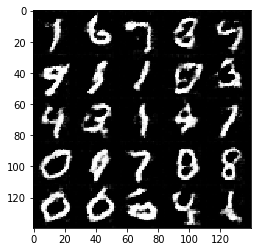

Epoch 1/2... Step: 1210... Discriminator Loss: 2.3702... Generator Loss: 0.1311
Epoch 1/2... Step: 1220... Discriminator Loss: 0.9423... Generator Loss: 0.8154
Epoch 1/2... Step: 1230... Discriminator Loss: 1.5148... Generator Loss: 0.3410
Epoch 1/2... Step: 1240... Discriminator Loss: 0.8631... Generator Loss: 0.7758
Epoch 1/2... Step: 1250... Discriminator Loss: 1.4607... Generator Loss: 0.3460
Epoch 1/2... Step: 1260... Discriminator Loss: 1.1648... Generator Loss: 0.4997
Epoch 1/2... Step: 1270... Discriminator Loss: 1.4258... Generator Loss: 0.3433
Epoch 1/2... Step: 1280... Discriminator Loss: 0.8865... Generator Loss: 0.8912
Epoch 1/2... Step: 1290... Discriminator Loss: 1.9654... Generator Loss: 0.1851
Epoch 1/2... Step: 1300... Discriminator Loss: 0.8570... Generator Loss: 1.0867
Cumulative Average Generator Loss / Discriminator Loss: 0.5815638303756714
Current Generator Loss / Discriminator Loss: 1.2679907083511353


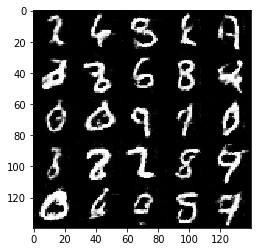

Epoch 1/2... Step: 1310... Discriminator Loss: 1.0303... Generator Loss: 1.3430
Epoch 1/2... Step: 1320... Discriminator Loss: 0.9569... Generator Loss: 0.6373
Epoch 1/2... Step: 1330... Discriminator Loss: 0.9807... Generator Loss: 0.6558
Epoch 1/2... Step: 1340... Discriminator Loss: 0.9727... Generator Loss: 0.9912
Epoch 1/2... Step: 1350... Discriminator Loss: 0.7063... Generator Loss: 2.0825
Epoch 1/2... Step: 1360... Discriminator Loss: 0.9693... Generator Loss: 0.6748
Epoch 1/2... Step: 1370... Discriminator Loss: 0.6248... Generator Loss: 1.6679
Epoch 1/2... Step: 1380... Discriminator Loss: 1.9210... Generator Loss: 0.1937
Epoch 1/2... Step: 1390... Discriminator Loss: 1.7737... Generator Loss: 0.2249
Epoch 1/2... Step: 1400... Discriminator Loss: 0.6642... Generator Loss: 1.1451
Cumulative Average Generator Loss / Discriminator Loss: 0.6010752320289612
Current Generator Loss / Discriminator Loss: 1.7240861654281616


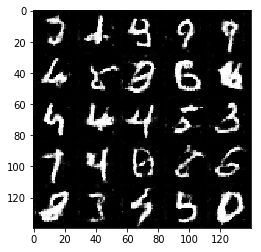

Epoch 1/2... Step: 1410... Discriminator Loss: 0.9204... Generator Loss: 0.6997
Epoch 1/2... Step: 1420... Discriminator Loss: 0.8087... Generator Loss: 1.9562
Epoch 1/2... Step: 1430... Discriminator Loss: 2.0231... Generator Loss: 0.1772
Epoch 1/2... Step: 1440... Discriminator Loss: 1.0250... Generator Loss: 0.6175
Epoch 1/2... Step: 1450... Discriminator Loss: 1.2816... Generator Loss: 0.4872
Epoch 1/2... Step: 1460... Discriminator Loss: 0.7590... Generator Loss: 0.9113
Epoch 1/2... Step: 1470... Discriminator Loss: 2.0079... Generator Loss: 0.1903
Epoch 1/2... Step: 1480... Discriminator Loss: 1.1373... Generator Loss: 0.5780
Epoch 1/2... Step: 1490... Discriminator Loss: 0.9789... Generator Loss: 0.7115
Epoch 1/2... Step: 1500... Discriminator Loss: 2.3141... Generator Loss: 0.1340
Cumulative Average Generator Loss / Discriminator Loss: 0.5931607484817505
Current Generator Loss / Discriminator Loss: 0.057914771139621735


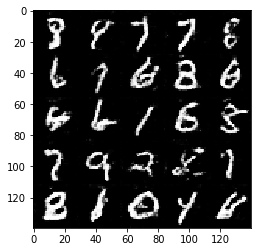

Epoch 1/2... Step: 1510... Discriminator Loss: 0.8718... Generator Loss: 0.7226
Epoch 1/2... Step: 1520... Discriminator Loss: 1.6744... Generator Loss: 0.2444
Epoch 1/2... Step: 1530... Discriminator Loss: 1.4256... Generator Loss: 0.3594
Epoch 1/2... Step: 1540... Discriminator Loss: 1.0152... Generator Loss: 0.6562
Epoch 1/2... Step: 1550... Discriminator Loss: 1.0108... Generator Loss: 0.6394
Epoch 1/2... Step: 1560... Discriminator Loss: 0.7374... Generator Loss: 1.1516
Epoch 1/2... Step: 1570... Discriminator Loss: 0.7620... Generator Loss: 0.9233
Epoch 1/2... Step: 1580... Discriminator Loss: 1.0121... Generator Loss: 0.6137
Epoch 1/2... Step: 1590... Discriminator Loss: 1.6233... Generator Loss: 0.2852
Epoch 1/2... Step: 1600... Discriminator Loss: 1.2695... Generator Loss: 0.3829
Cumulative Average Generator Loss / Discriminator Loss: 0.5892677903175354
Current Generator Loss / Discriminator Loss: 0.30159398913383484


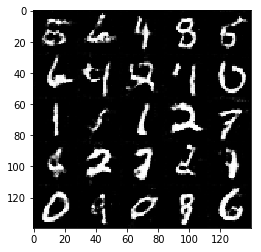

Epoch 1/2... Step: 1610... Discriminator Loss: 1.1415... Generator Loss: 0.4733
Epoch 1/2... Step: 1620... Discriminator Loss: 0.9099... Generator Loss: 1.5706
Epoch 1/2... Step: 1630... Discriminator Loss: 1.1574... Generator Loss: 0.5326
Epoch 1/2... Step: 1640... Discriminator Loss: 1.1493... Generator Loss: 0.5416
Epoch 1/2... Step: 1650... Discriminator Loss: 0.7479... Generator Loss: 1.1314
Epoch 1/2... Step: 1660... Discriminator Loss: 1.1126... Generator Loss: 0.5187
Epoch 1/2... Step: 1670... Discriminator Loss: 0.6616... Generator Loss: 1.3648
Epoch 1/2... Step: 1680... Discriminator Loss: 1.0716... Generator Loss: 0.5204
Epoch 1/2... Step: 1690... Discriminator Loss: 0.8104... Generator Loss: 1.1453
Epoch 1/2... Step: 1700... Discriminator Loss: 0.9236... Generator Loss: 0.6542
Cumulative Average Generator Loss / Discriminator Loss: 0.6022632718086243
Current Generator Loss / Discriminator Loss: 0.7082644701004028


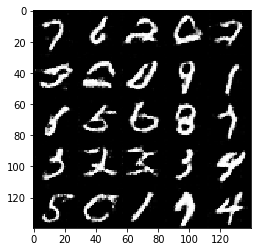

Epoch 1/2... Step: 1710... Discriminator Loss: 0.6351... Generator Loss: 1.6305
Epoch 1/2... Step: 1720... Discriminator Loss: 0.9388... Generator Loss: 0.6904
Epoch 1/2... Step: 1730... Discriminator Loss: 1.2776... Generator Loss: 0.4096
Epoch 1/2... Step: 1740... Discriminator Loss: 0.8428... Generator Loss: 0.7523
Epoch 1/2... Step: 1750... Discriminator Loss: 0.6408... Generator Loss: 1.0179
Epoch 1/2... Step: 1760... Discriminator Loss: 1.3536... Generator Loss: 0.4061
Epoch 1/2... Step: 1770... Discriminator Loss: 0.8984... Generator Loss: 0.7590
Epoch 1/2... Step: 1780... Discriminator Loss: 1.3403... Generator Loss: 0.3948
Epoch 1/2... Step: 1790... Discriminator Loss: 2.3094... Generator Loss: 0.1314
Epoch 1/2... Step: 1800... Discriminator Loss: 0.7634... Generator Loss: 0.9046
Cumulative Average Generator Loss / Discriminator Loss: 0.6043851375579834
Current Generator Loss / Discriminator Loss: 1.1848247051239014


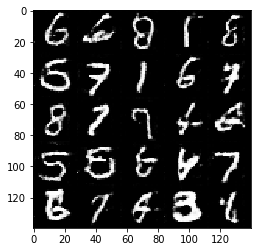

Epoch 1/2... Step: 1810... Discriminator Loss: 0.9165... Generator Loss: 0.6293
Epoch 1/2... Step: 1820... Discriminator Loss: 1.2539... Generator Loss: 1.2391
Epoch 1/2... Step: 1830... Discriminator Loss: 1.2573... Generator Loss: 0.5566
Epoch 1/2... Step: 1840... Discriminator Loss: 1.0958... Generator Loss: 0.5143
Epoch 1/2... Step: 1850... Discriminator Loss: 1.0132... Generator Loss: 0.6236
Epoch 1/2... Step: 1860... Discriminator Loss: 0.6368... Generator Loss: 1.1408
Epoch 1/2... Step: 1870... Discriminator Loss: 1.0936... Generator Loss: 0.4981
Epoch 2/2... Step: 1880... Discriminator Loss: 0.9094... Generator Loss: 1.8976
Epoch 2/2... Step: 1890... Discriminator Loss: 0.9464... Generator Loss: 1.2160
Epoch 2/2... Step: 1900... Discriminator Loss: 0.6777... Generator Loss: 1.5520
Cumulative Average Generator Loss / Discriminator Loss: 0.621380627155304
Current Generator Loss / Discriminator Loss: 2.2901713848114014


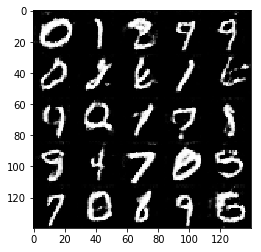

Epoch 2/2... Step: 1910... Discriminator Loss: 0.8239... Generator Loss: 0.8029
Epoch 2/2... Step: 1920... Discriminator Loss: 0.7853... Generator Loss: 0.7907
Epoch 2/2... Step: 1930... Discriminator Loss: 1.1117... Generator Loss: 0.5151
Epoch 2/2... Step: 1940... Discriminator Loss: 1.2804... Generator Loss: 2.3473
Epoch 2/2... Step: 1950... Discriminator Loss: 0.9911... Generator Loss: 0.6386
Epoch 2/2... Step: 1960... Discriminator Loss: 1.4117... Generator Loss: 0.3640
Epoch 2/2... Step: 1970... Discriminator Loss: 1.5380... Generator Loss: 0.2991
Epoch 2/2... Step: 1980... Discriminator Loss: 0.9906... Generator Loss: 0.6343
Epoch 2/2... Step: 1990... Discriminator Loss: 1.0572... Generator Loss: 0.5547
Epoch 2/2... Step: 2000... Discriminator Loss: 0.7275... Generator Loss: 1.0031
Cumulative Average Generator Loss / Discriminator Loss: 0.6266950368881226
Current Generator Loss / Discriminator Loss: 1.3789043426513672


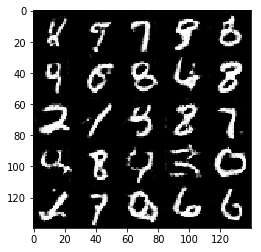

Epoch 2/2... Step: 2010... Discriminator Loss: 1.5478... Generator Loss: 0.3062
Epoch 2/2... Step: 2020... Discriminator Loss: 2.2655... Generator Loss: 0.1330
Epoch 2/2... Step: 2030... Discriminator Loss: 1.8403... Generator Loss: 0.2104
Epoch 2/2... Step: 2040... Discriminator Loss: 1.5785... Generator Loss: 0.3007
Epoch 2/2... Step: 2050... Discriminator Loss: 1.4118... Generator Loss: 0.3789
Epoch 2/2... Step: 2060... Discriminator Loss: 1.5557... Generator Loss: 0.3011
Epoch 2/2... Step: 2070... Discriminator Loss: 1.4457... Generator Loss: 0.3460
Epoch 2/2... Step: 2080... Discriminator Loss: 0.9353... Generator Loss: 1.3387
Epoch 2/2... Step: 2090... Discriminator Loss: 1.3315... Generator Loss: 0.3791
Epoch 2/2... Step: 2100... Discriminator Loss: 0.6350... Generator Loss: 1.2961
Cumulative Average Generator Loss / Discriminator Loss: 0.6106590628623962
Current Generator Loss / Discriminator Loss: 2.041001081466675


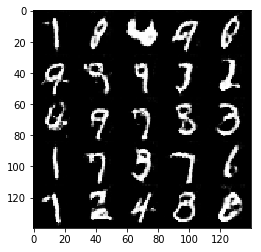

Epoch 2/2... Step: 2110... Discriminator Loss: 1.0098... Generator Loss: 0.5968
Epoch 2/2... Step: 2120... Discriminator Loss: 1.0407... Generator Loss: 0.6960
Epoch 2/2... Step: 2130... Discriminator Loss: 1.5919... Generator Loss: 0.3333
Epoch 2/2... Step: 2140... Discriminator Loss: 1.6297... Generator Loss: 0.2800
Epoch 2/2... Step: 2150... Discriminator Loss: 0.6719... Generator Loss: 1.5244
Epoch 2/2... Step: 2160... Discriminator Loss: 1.1211... Generator Loss: 0.6282
Epoch 2/2... Step: 2170... Discriminator Loss: 0.6445... Generator Loss: 1.0641
Epoch 2/2... Step: 2180... Discriminator Loss: 0.8682... Generator Loss: 0.8240
Epoch 2/2... Step: 2190... Discriminator Loss: 1.3376... Generator Loss: 0.4255
Epoch 2/2... Step: 2200... Discriminator Loss: 0.7854... Generator Loss: 1.1579
Cumulative Average Generator Loss / Discriminator Loss: 0.6143738031387329
Current Generator Loss / Discriminator Loss: 1.474191427230835


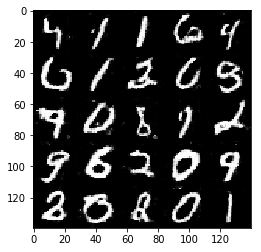

Epoch 2/2... Step: 2210... Discriminator Loss: 0.9055... Generator Loss: 0.6522
Epoch 2/2... Step: 2220... Discriminator Loss: 1.2641... Generator Loss: 0.4030
Epoch 2/2... Step: 2230... Discriminator Loss: 0.9690... Generator Loss: 0.7323
Epoch 2/2... Step: 2240... Discriminator Loss: 1.1511... Generator Loss: 0.4907
Epoch 2/2... Step: 2250... Discriminator Loss: 0.7515... Generator Loss: 0.9338
Epoch 2/2... Step: 2260... Discriminator Loss: 0.4942... Generator Loss: 1.3689
Epoch 2/2... Step: 2270... Discriminator Loss: 0.5183... Generator Loss: 1.6118
Epoch 2/2... Step: 2280... Discriminator Loss: 1.1579... Generator Loss: 0.4929
Epoch 2/2... Step: 2290... Discriminator Loss: 0.8525... Generator Loss: 1.1587
Epoch 2/2... Step: 2300... Discriminator Loss: 2.6181... Generator Loss: 0.1075
Cumulative Average Generator Loss / Discriminator Loss: 0.6193569302558899
Current Generator Loss / Discriminator Loss: 0.04105621948838234


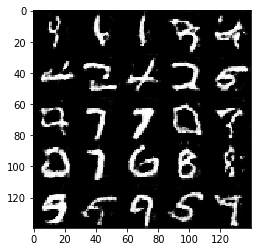

Epoch 2/2... Step: 2310... Discriminator Loss: 1.3903... Generator Loss: 0.3526
Epoch 2/2... Step: 2320... Discriminator Loss: 2.4056... Generator Loss: 0.1191
Epoch 2/2... Step: 2330... Discriminator Loss: 0.9448... Generator Loss: 0.8537
Epoch 2/2... Step: 2340... Discriminator Loss: 2.4321... Generator Loss: 0.1106
Epoch 2/2... Step: 2350... Discriminator Loss: 1.2042... Generator Loss: 0.4773
Epoch 2/2... Step: 2360... Discriminator Loss: 1.0742... Generator Loss: 0.5243
Epoch 2/2... Step: 2370... Discriminator Loss: 0.9361... Generator Loss: 0.7379
Epoch 2/2... Step: 2380... Discriminator Loss: 1.0826... Generator Loss: 1.4662
Epoch 2/2... Step: 2390... Discriminator Loss: 1.1198... Generator Loss: 0.9946
Epoch 2/2... Step: 2400... Discriminator Loss: 1.9517... Generator Loss: 0.1922
Cumulative Average Generator Loss / Discriminator Loss: 0.6085206270217896
Current Generator Loss / Discriminator Loss: 0.09848040342330933


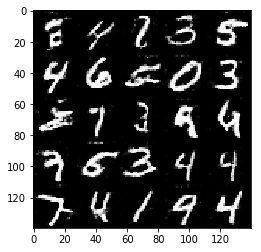

Epoch 2/2... Step: 2410... Discriminator Loss: 2.3898... Generator Loss: 0.1540
Epoch 2/2... Step: 2420... Discriminator Loss: 1.2087... Generator Loss: 0.4910
Epoch 2/2... Step: 2430... Discriminator Loss: 0.8597... Generator Loss: 0.8075
Epoch 2/2... Step: 2440... Discriminator Loss: 0.7754... Generator Loss: 0.8361
Epoch 2/2... Step: 2450... Discriminator Loss: 1.0344... Generator Loss: 0.5878
Epoch 2/2... Step: 2460... Discriminator Loss: 1.1708... Generator Loss: 0.4838
Epoch 2/2... Step: 2470... Discriminator Loss: 1.8867... Generator Loss: 0.2014
Epoch 2/2... Step: 2480... Discriminator Loss: 0.6078... Generator Loss: 1.3040
Epoch 2/2... Step: 2490... Discriminator Loss: 1.9835... Generator Loss: 0.1908
Epoch 2/2... Step: 2500... Discriminator Loss: 0.6609... Generator Loss: 1.0386
Cumulative Average Generator Loss / Discriminator Loss: 0.6034243702888489
Current Generator Loss / Discriminator Loss: 1.5715469121932983


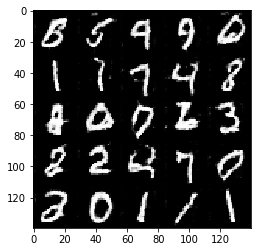

Epoch 2/2... Step: 2510... Discriminator Loss: 0.7607... Generator Loss: 1.0077
Epoch 2/2... Step: 2520... Discriminator Loss: 1.2826... Generator Loss: 0.5306
Epoch 2/2... Step: 2530... Discriminator Loss: 1.8454... Generator Loss: 0.2320
Epoch 2/2... Step: 2540... Discriminator Loss: 1.5335... Generator Loss: 0.3229
Epoch 2/2... Step: 2550... Discriminator Loss: 0.5613... Generator Loss: 1.5277
Epoch 2/2... Step: 2560... Discriminator Loss: 1.3164... Generator Loss: 0.4020
Epoch 2/2... Step: 2570... Discriminator Loss: 1.5626... Generator Loss: 0.3135
Epoch 2/2... Step: 2580... Discriminator Loss: 1.0923... Generator Loss: 0.5169
Epoch 2/2... Step: 2590... Discriminator Loss: 1.7829... Generator Loss: 0.2233
Epoch 2/2... Step: 2600... Discriminator Loss: 0.8628... Generator Loss: 1.1057
Cumulative Average Generator Loss / Discriminator Loss: 0.598961353302002
Current Generator Loss / Discriminator Loss: 1.2815635204315186


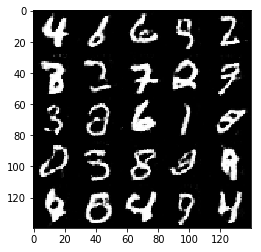

Epoch 2/2... Step: 2610... Discriminator Loss: 1.1721... Generator Loss: 1.9967
Epoch 2/2... Step: 2620... Discriminator Loss: 1.2548... Generator Loss: 0.5100
Epoch 2/2... Step: 2630... Discriminator Loss: 1.3314... Generator Loss: 0.3688
Epoch 2/2... Step: 2640... Discriminator Loss: 1.0572... Generator Loss: 0.5941
Epoch 2/2... Step: 2650... Discriminator Loss: 1.1186... Generator Loss: 2.0373
Epoch 2/2... Step: 2660... Discriminator Loss: 1.6555... Generator Loss: 0.2920
Epoch 2/2... Step: 2670... Discriminator Loss: 0.5453... Generator Loss: 1.1481
Epoch 2/2... Step: 2680... Discriminator Loss: 1.5608... Generator Loss: 0.2906
Epoch 2/2... Step: 2690... Discriminator Loss: 0.9032... Generator Loss: 0.6714
Epoch 2/2... Step: 2700... Discriminator Loss: 1.0387... Generator Loss: 0.7039
Cumulative Average Generator Loss / Discriminator Loss: 0.6039379835128784
Current Generator Loss / Discriminator Loss: 0.6776854395866394


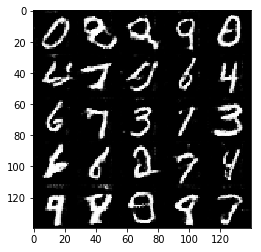

Epoch 2/2... Step: 2710... Discriminator Loss: 0.7267... Generator Loss: 0.8607
Epoch 2/2... Step: 2720... Discriminator Loss: 0.7832... Generator Loss: 0.8085
Epoch 2/2... Step: 2730... Discriminator Loss: 1.7048... Generator Loss: 0.2761
Epoch 2/2... Step: 2740... Discriminator Loss: 1.1199... Generator Loss: 0.5226
Epoch 2/2... Step: 2750... Discriminator Loss: 1.0213... Generator Loss: 2.4811
Epoch 2/2... Step: 2760... Discriminator Loss: 0.8414... Generator Loss: 0.7266
Epoch 2/2... Step: 2770... Discriminator Loss: 0.7918... Generator Loss: 1.6130
Epoch 2/2... Step: 2780... Discriminator Loss: 0.6376... Generator Loss: 1.0563
Epoch 2/2... Step: 2790... Discriminator Loss: 0.6210... Generator Loss: 0.9503
Epoch 2/2... Step: 2800... Discriminator Loss: 0.7517... Generator Loss: 0.8098
Cumulative Average Generator Loss / Discriminator Loss: 0.6177108287811279
Current Generator Loss / Discriminator Loss: 1.0773409605026245


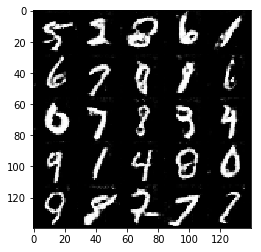

Epoch 2/2... Step: 2810... Discriminator Loss: 0.5117... Generator Loss: 2.2463
Epoch 2/2... Step: 2820... Discriminator Loss: 1.2510... Generator Loss: 2.2432
Epoch 2/2... Step: 2830... Discriminator Loss: 1.7186... Generator Loss: 0.2464
Epoch 2/2... Step: 2840... Discriminator Loss: 1.3143... Generator Loss: 0.3802
Epoch 2/2... Step: 2850... Discriminator Loss: 1.0453... Generator Loss: 0.5706
Epoch 2/2... Step: 2860... Discriminator Loss: 0.6935... Generator Loss: 0.9382
Epoch 2/2... Step: 2870... Discriminator Loss: 1.0333... Generator Loss: 0.5278
Epoch 2/2... Step: 2880... Discriminator Loss: 0.7101... Generator Loss: 1.5015
Epoch 2/2... Step: 2890... Discriminator Loss: 0.6901... Generator Loss: 1.3954
Epoch 2/2... Step: 2900... Discriminator Loss: 0.9869... Generator Loss: 0.6435
Cumulative Average Generator Loss / Discriminator Loss: 0.6307299137115479
Current Generator Loss / Discriminator Loss: 0.6521122455596924


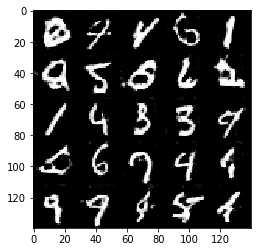

Epoch 2/2... Step: 2910... Discriminator Loss: 0.7638... Generator Loss: 1.1117
Epoch 2/2... Step: 2920... Discriminator Loss: 0.7280... Generator Loss: 0.9766
Epoch 2/2... Step: 2930... Discriminator Loss: 0.8074... Generator Loss: 2.6126
Epoch 2/2... Step: 2940... Discriminator Loss: 0.4506... Generator Loss: 1.4578
Epoch 2/2... Step: 2950... Discriminator Loss: 0.7651... Generator Loss: 2.2901
Epoch 2/2... Step: 2960... Discriminator Loss: 1.4798... Generator Loss: 0.3073
Epoch 2/2... Step: 2970... Discriminator Loss: 1.4477... Generator Loss: 0.3255
Epoch 2/2... Step: 2980... Discriminator Loss: 0.7632... Generator Loss: 1.3155
Epoch 2/2... Step: 2990... Discriminator Loss: 1.0919... Generator Loss: 0.5325
Epoch 2/2... Step: 3000... Discriminator Loss: 1.9082... Generator Loss: 0.2085
Cumulative Average Generator Loss / Discriminator Loss: 0.6438166499137878
Current Generator Loss / Discriminator Loss: 0.10925367474555969


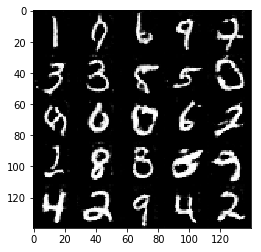

Epoch 2/2... Step: 3010... Discriminator Loss: 0.6064... Generator Loss: 1.2748
Epoch 2/2... Step: 3020... Discriminator Loss: 1.7553... Generator Loss: 0.2742
Epoch 2/2... Step: 3030... Discriminator Loss: 1.3550... Generator Loss: 0.3639
Epoch 2/2... Step: 3040... Discriminator Loss: 1.2822... Generator Loss: 0.4498
Epoch 2/2... Step: 3050... Discriminator Loss: 2.6264... Generator Loss: 0.1137
Epoch 2/2... Step: 3060... Discriminator Loss: 0.6533... Generator Loss: 1.2426
Epoch 2/2... Step: 3070... Discriminator Loss: 1.0084... Generator Loss: 0.6053
Epoch 2/2... Step: 3080... Discriminator Loss: 1.6435... Generator Loss: 0.2751
Epoch 2/2... Step: 3090... Discriminator Loss: 0.6807... Generator Loss: 1.0299
Epoch 2/2... Step: 3100... Discriminator Loss: 0.7299... Generator Loss: 1.1821
Cumulative Average Generator Loss / Discriminator Loss: 0.6407641768455505
Current Generator Loss / Discriminator Loss: 1.6194933652877808


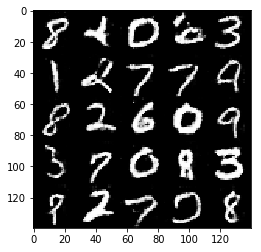

Epoch 2/2... Step: 3110... Discriminator Loss: 1.2207... Generator Loss: 0.4436
Epoch 2/2... Step: 3120... Discriminator Loss: 1.1529... Generator Loss: 0.5134
Epoch 2/2... Step: 3130... Discriminator Loss: 0.4619... Generator Loss: 1.5315
Epoch 2/2... Step: 3140... Discriminator Loss: 0.6137... Generator Loss: 1.7694
Epoch 2/2... Step: 3150... Discriminator Loss: 1.9051... Generator Loss: 0.2023
Epoch 2/2... Step: 3160... Discriminator Loss: 1.2453... Generator Loss: 0.4154
Epoch 2/2... Step: 3170... Discriminator Loss: 0.5356... Generator Loss: 1.1447
Epoch 2/2... Step: 3180... Discriminator Loss: 1.0475... Generator Loss: 0.5662
Epoch 2/2... Step: 3190... Discriminator Loss: 1.0984... Generator Loss: 0.4989
Epoch 2/2... Step: 3200... Discriminator Loss: 0.7529... Generator Loss: 1.7363
Cumulative Average Generator Loss / Discriminator Loss: 0.6470332741737366
Current Generator Loss / Discriminator Loss: 2.3062126636505127


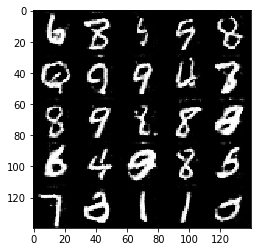

Epoch 2/2... Step: 3210... Discriminator Loss: 1.7556... Generator Loss: 0.2370
Epoch 2/2... Step: 3220... Discriminator Loss: 0.5707... Generator Loss: 1.4101
Epoch 2/2... Step: 3230... Discriminator Loss: 1.2864... Generator Loss: 0.4505
Epoch 2/2... Step: 3240... Discriminator Loss: 2.0596... Generator Loss: 0.1835
Epoch 2/2... Step: 3250... Discriminator Loss: 0.7038... Generator Loss: 1.1302
Epoch 2/2... Step: 3260... Discriminator Loss: 1.0691... Generator Loss: 0.5417
Epoch 2/2... Step: 3270... Discriminator Loss: 1.1404... Generator Loss: 0.5430
Epoch 2/2... Step: 3280... Discriminator Loss: 1.6541... Generator Loss: 0.2769
Epoch 2/2... Step: 3290... Discriminator Loss: 1.0143... Generator Loss: 0.5854
Epoch 2/2... Step: 3300... Discriminator Loss: 1.0324... Generator Loss: 0.5615
Cumulative Average Generator Loss / Discriminator Loss: 0.641879677772522
Current Generator Loss / Discriminator Loss: 0.5438992977142334


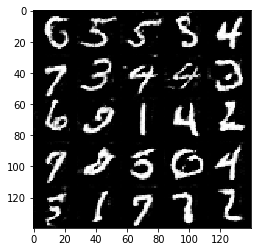

Epoch 2/2... Step: 3310... Discriminator Loss: 1.4443... Generator Loss: 0.3616
Epoch 2/2... Step: 3320... Discriminator Loss: 0.9882... Generator Loss: 0.5894
Epoch 2/2... Step: 3330... Discriminator Loss: 0.7778... Generator Loss: 2.0714
Epoch 2/2... Step: 3340... Discriminator Loss: 0.9564... Generator Loss: 0.6090
Epoch 2/2... Step: 3350... Discriminator Loss: 1.5882... Generator Loss: 0.2704
Epoch 2/2... Step: 3360... Discriminator Loss: 1.0995... Generator Loss: 0.5124
Epoch 2/2... Step: 3370... Discriminator Loss: 1.1028... Generator Loss: 0.5217
Epoch 2/2... Step: 3380... Discriminator Loss: 0.9246... Generator Loss: 1.2724
Epoch 2/2... Step: 3390... Discriminator Loss: 1.6862... Generator Loss: 0.2559
Epoch 2/2... Step: 3400... Discriminator Loss: 2.2723... Generator Loss: 0.1458
Cumulative Average Generator Loss / Discriminator Loss: 0.6378673911094666
Current Generator Loss / Discriminator Loss: 0.06418458372354507


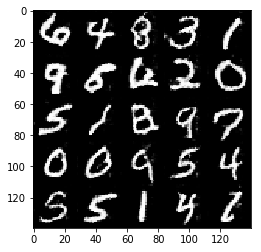

Epoch 2/2... Step: 3410... Discriminator Loss: 1.1976... Generator Loss: 0.4647
Epoch 2/2... Step: 3420... Discriminator Loss: 0.6610... Generator Loss: 0.8822
Epoch 2/2... Step: 3430... Discriminator Loss: 1.7778... Generator Loss: 0.2617
Epoch 2/2... Step: 3440... Discriminator Loss: 1.0461... Generator Loss: 0.5773
Epoch 2/2... Step: 3450... Discriminator Loss: 2.2687... Generator Loss: 0.1363
Epoch 2/2... Step: 3460... Discriminator Loss: 1.0370... Generator Loss: 0.5605
Epoch 2/2... Step: 3470... Discriminator Loss: 0.6107... Generator Loss: 1.1287
Epoch 2/2... Step: 3480... Discriminator Loss: 2.2762... Generator Loss: 0.1486
Epoch 2/2... Step: 3490... Discriminator Loss: 1.4539... Generator Loss: 0.3251
Epoch 2/2... Step: 3500... Discriminator Loss: 1.3436... Generator Loss: 2.2645
Cumulative Average Generator Loss / Discriminator Loss: 0.6331775784492493
Current Generator Loss / Discriminator Loss: 1.6854405403137207


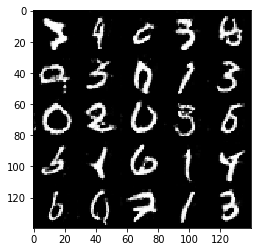

Epoch 2/2... Step: 3510... Discriminator Loss: 1.6583... Generator Loss: 0.2512
Epoch 2/2... Step: 3520... Discriminator Loss: 0.7508... Generator Loss: 0.7686
Epoch 2/2... Step: 3530... Discriminator Loss: 1.5161... Generator Loss: 0.3744
Epoch 2/2... Step: 3540... Discriminator Loss: 0.9702... Generator Loss: 0.6570
Epoch 2/2... Step: 3550... Discriminator Loss: 0.8181... Generator Loss: 0.8001
Epoch 2/2... Step: 3560... Discriminator Loss: 2.8220... Generator Loss: 0.0730
Epoch 2/2... Step: 3570... Discriminator Loss: 1.0646... Generator Loss: 0.5258
Epoch 2/2... Step: 3580... Discriminator Loss: 0.4399... Generator Loss: 2.0219
Epoch 2/2... Step: 3590... Discriminator Loss: 0.9313... Generator Loss: 0.6249
Epoch 2/2... Step: 3600... Discriminator Loss: 1.0535... Generator Loss: 0.5014
Cumulative Average Generator Loss / Discriminator Loss: 0.630828857421875
Current Generator Loss / Discriminator Loss: 0.475951224565506


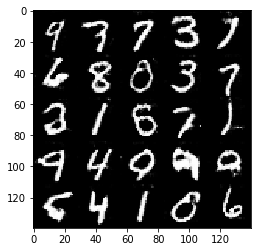

Epoch 2/2... Step: 3610... Discriminator Loss: 0.9974... Generator Loss: 0.6200
Epoch 2/2... Step: 3620... Discriminator Loss: 0.8939... Generator Loss: 0.6834
Epoch 2/2... Step: 3630... Discriminator Loss: 1.1270... Generator Loss: 0.5153
Epoch 2/2... Step: 3640... Discriminator Loss: 0.8972... Generator Loss: 0.7324
Epoch 2/2... Step: 3650... Discriminator Loss: 1.7377... Generator Loss: 0.2734
Epoch 2/2... Step: 3660... Discriminator Loss: 1.3579... Generator Loss: 0.3977
Epoch 2/2... Step: 3670... Discriminator Loss: 1.0666... Generator Loss: 0.5341
Epoch 2/2... Step: 3680... Discriminator Loss: 1.2871... Generator Loss: 0.4040
Epoch 2/2... Step: 3690... Discriminator Loss: 1.1708... Generator Loss: 0.4712
Epoch 2/2... Step: 3700... Discriminator Loss: 1.3814... Generator Loss: 0.3621
Cumulative Average Generator Loss / Discriminator Loss: 0.625148594379425
Current Generator Loss / Discriminator Loss: 0.26213130354881287


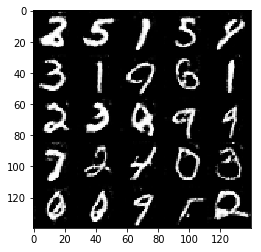

Epoch 2/2... Step: 3710... Discriminator Loss: 1.5531... Generator Loss: 0.3117
Epoch 2/2... Step: 3720... Discriminator Loss: 1.5693... Generator Loss: 0.2855
Epoch 2/2... Step: 3730... Discriminator Loss: 2.5526... Generator Loss: 0.1107
Epoch 2/2... Step: 3740... Discriminator Loss: 1.0078... Generator Loss: 0.5215
Epoch 2/2... Step: 3750... Discriminator Loss: 0.8740... Generator Loss: 0.6883


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
alpha = 0.1
beta1 = 0.2
dropout = 0.2

epochs = 2

mnist_dataset = Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

ganTrainer = GANTrainer()

with tf.Graph().as_default():
    ganTrainer.train_gan(epochs, batch_size, 
                         z_dim, learning_rate, 
                         alpha, beta1, dropout,
                         mnist_dataset.get_batches,
                         mnist_dataset.shape, 
                         mnist_dataset.image_mode)

## Training Model on CELEBA Dataset

Epoch 1/1... Step: 10... Discriminator Loss: 0.6635... Generator Loss: 0.8946
Epoch 1/1... Step: 20... Discriminator Loss: 0.0677... Generator Loss: 4.0983
Epoch 1/1... Step: 30... Discriminator Loss: 2.5984... Generator Loss: 0.0887
Epoch 1/1... Step: 40... Discriminator Loss: 0.3156... Generator Loss: 4.2068
Epoch 1/1... Step: 50... Discriminator Loss: 0.8143... Generator Loss: 5.7252
Epoch 1/1... Step: 60... Discriminator Loss: 0.2880... Generator Loss: 3.5725
Epoch 1/1... Step: 70... Discriminator Loss: 1.2923... Generator Loss: 0.4133
Epoch 1/1... Step: 80... Discriminator Loss: 1.0233... Generator Loss: 1.6855
Epoch 1/1... Step: 90... Discriminator Loss: 0.9706... Generator Loss: 2.4979
Epoch 1/1... Step: 100... Discriminator Loss: 0.7979... Generator Loss: 1.3531
Cumulative Average Generator Loss / Discriminator Loss: 2.7782249450683594
Current Generator Loss / Discriminator Loss: 1.6959505081176758


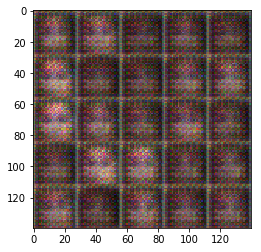

Epoch 1/1... Step: 110... Discriminator Loss: 1.5798... Generator Loss: 0.3451
Epoch 1/1... Step: 120... Discriminator Loss: 2.1191... Generator Loss: 0.1630
Epoch 1/1... Step: 130... Discriminator Loss: 1.3527... Generator Loss: 0.4806
Epoch 1/1... Step: 140... Discriminator Loss: 0.9963... Generator Loss: 2.0307
Epoch 1/1... Step: 150... Discriminator Loss: 1.0634... Generator Loss: 0.7207
Epoch 1/1... Step: 160... Discriminator Loss: 1.5482... Generator Loss: 0.2956
Epoch 1/1... Step: 170... Discriminator Loss: 0.9455... Generator Loss: 1.6345
Epoch 1/1... Step: 180... Discriminator Loss: 0.9051... Generator Loss: 1.7573
Epoch 1/1... Step: 190... Discriminator Loss: 0.9331... Generator Loss: 0.9054
Epoch 1/1... Step: 200... Discriminator Loss: 0.8927... Generator Loss: 1.0168
Cumulative Average Generator Loss / Discriminator Loss: 1.6008514165878296
Current Generator Loss / Discriminator Loss: 1.1391055583953857


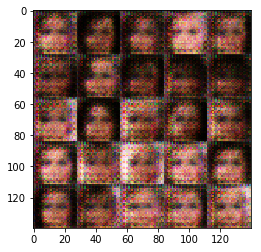

Epoch 1/1... Step: 210... Discriminator Loss: 0.8350... Generator Loss: 1.1922
Epoch 1/1... Step: 220... Discriminator Loss: 1.3495... Generator Loss: 0.3748
Epoch 1/1... Step: 230... Discriminator Loss: 0.8446... Generator Loss: 0.8294
Epoch 1/1... Step: 240... Discriminator Loss: 0.7577... Generator Loss: 1.0570
Epoch 1/1... Step: 250... Discriminator Loss: 0.6515... Generator Loss: 1.8858
Epoch 1/1... Step: 260... Discriminator Loss: 1.4812... Generator Loss: 0.3596
Epoch 1/1... Step: 270... Discriminator Loss: 0.6562... Generator Loss: 1.5018
Epoch 1/1... Step: 280... Discriminator Loss: 1.2925... Generator Loss: 0.4285
Epoch 1/1... Step: 290... Discriminator Loss: 0.9042... Generator Loss: 0.9404
Epoch 1/1... Step: 300... Discriminator Loss: 1.6191... Generator Loss: 0.2624
Cumulative Average Generator Loss / Discriminator Loss: 1.353589653968811
Current Generator Loss / Discriminator Loss: 0.162033811211586


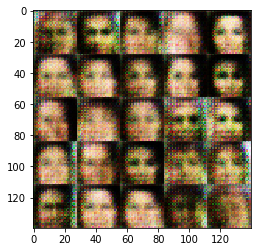

Epoch 1/1... Step: 310... Discriminator Loss: 1.5782... Generator Loss: 0.2862
Epoch 1/1... Step: 320... Discriminator Loss: 0.8532... Generator Loss: 1.2097
Epoch 1/1... Step: 330... Discriminator Loss: 0.9071... Generator Loss: 0.8189
Epoch 1/1... Step: 340... Discriminator Loss: 1.0748... Generator Loss: 2.0204
Epoch 1/1... Step: 350... Discriminator Loss: 1.2643... Generator Loss: 0.4033
Epoch 1/1... Step: 360... Discriminator Loss: 0.7415... Generator Loss: 1.1765
Epoch 1/1... Step: 370... Discriminator Loss: 1.6070... Generator Loss: 0.3223
Epoch 1/1... Step: 380... Discriminator Loss: 1.3255... Generator Loss: 0.3968
Epoch 1/1... Step: 390... Discriminator Loss: 1.3565... Generator Loss: 0.4870
Epoch 1/1... Step: 400... Discriminator Loss: 0.9135... Generator Loss: 2.1163
Cumulative Average Generator Loss / Discriminator Loss: 1.2032068967819214
Current Generator Loss / Discriminator Loss: 2.316586971282959


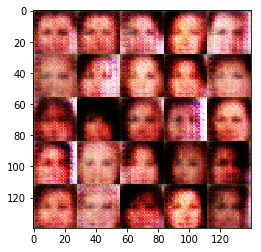

Epoch 1/1... Step: 410... Discriminator Loss: 1.8758... Generator Loss: 0.2376
Epoch 1/1... Step: 420... Discriminator Loss: 1.0230... Generator Loss: 0.7793
Epoch 1/1... Step: 430... Discriminator Loss: 1.6412... Generator Loss: 0.2676
Epoch 1/1... Step: 440... Discriminator Loss: 1.0140... Generator Loss: 0.9368
Epoch 1/1... Step: 450... Discriminator Loss: 0.9921... Generator Loss: 0.7278
Epoch 1/1... Step: 460... Discriminator Loss: 1.3797... Generator Loss: 0.4058
Epoch 1/1... Step: 470... Discriminator Loss: 1.0778... Generator Loss: 0.8202
Epoch 1/1... Step: 480... Discriminator Loss: 1.2717... Generator Loss: 0.5317
Epoch 1/1... Step: 490... Discriminator Loss: 1.3264... Generator Loss: 0.4331
Epoch 1/1... Step: 500... Discriminator Loss: 1.2001... Generator Loss: 0.8652
Cumulative Average Generator Loss / Discriminator Loss: 1.0353291034698486
Current Generator Loss / Discriminator Loss: 0.7209521532058716


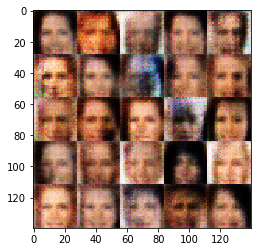

Epoch 1/1... Step: 510... Discriminator Loss: 1.0716... Generator Loss: 0.7619
Epoch 1/1... Step: 520... Discriminator Loss: 1.0939... Generator Loss: 0.8532
Epoch 1/1... Step: 530... Discriminator Loss: 1.9297... Generator Loss: 0.1982
Epoch 1/1... Step: 540... Discriminator Loss: 1.7159... Generator Loss: 0.2330
Epoch 1/1... Step: 550... Discriminator Loss: 0.9851... Generator Loss: 1.0714
Epoch 1/1... Step: 560... Discriminator Loss: 0.9551... Generator Loss: 0.9083
Epoch 1/1... Step: 570... Discriminator Loss: 1.9440... Generator Loss: 0.1836
Epoch 1/1... Step: 580... Discriminator Loss: 1.0305... Generator Loss: 0.6183
Epoch 1/1... Step: 590... Discriminator Loss: 1.0156... Generator Loss: 0.9335
Epoch 1/1... Step: 600... Discriminator Loss: 1.4580... Generator Loss: 0.3880
Cumulative Average Generator Loss / Discriminator Loss: 0.9266802668571472
Current Generator Loss / Discriminator Loss: 0.2661043107509613


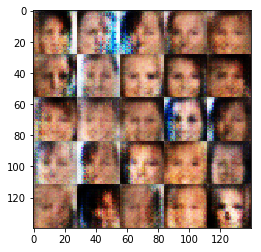

Epoch 1/1... Step: 610... Discriminator Loss: 1.2037... Generator Loss: 0.5143
Epoch 1/1... Step: 620... Discriminator Loss: 1.1546... Generator Loss: 0.6124
Epoch 1/1... Step: 630... Discriminator Loss: 0.8495... Generator Loss: 1.6415
Epoch 1/1... Step: 640... Discriminator Loss: 1.1641... Generator Loss: 1.3389
Epoch 1/1... Step: 650... Discriminator Loss: 2.1518... Generator Loss: 0.1569
Epoch 1/1... Step: 660... Discriminator Loss: 0.8895... Generator Loss: 0.8604
Epoch 1/1... Step: 670... Discriminator Loss: 0.8893... Generator Loss: 0.9994
Epoch 1/1... Step: 680... Discriminator Loss: 1.2009... Generator Loss: 0.6593
Epoch 1/1... Step: 690... Discriminator Loss: 0.5027... Generator Loss: 1.5359
Epoch 1/1... Step: 700... Discriminator Loss: 1.7934... Generator Loss: 0.2296
Cumulative Average Generator Loss / Discriminator Loss: 0.8972197771072388
Current Generator Loss / Discriminator Loss: 0.12803217768669128


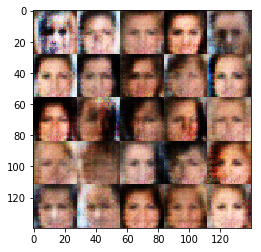

Epoch 1/1... Step: 710... Discriminator Loss: 0.7397... Generator Loss: 2.0950
Epoch 1/1... Step: 720... Discriminator Loss: 1.3352... Generator Loss: 0.4146
Epoch 1/1... Step: 730... Discriminator Loss: 1.1569... Generator Loss: 0.4990
Epoch 1/1... Step: 740... Discriminator Loss: 1.2201... Generator Loss: 0.5813
Epoch 1/1... Step: 750... Discriminator Loss: 1.1867... Generator Loss: 0.5057
Epoch 1/1... Step: 760... Discriminator Loss: 1.0268... Generator Loss: 1.0027
Epoch 1/1... Step: 770... Discriminator Loss: 1.2320... Generator Loss: 0.6060
Epoch 1/1... Step: 780... Discriminator Loss: 1.0703... Generator Loss: 0.7044
Epoch 1/1... Step: 790... Discriminator Loss: 1.4764... Generator Loss: 0.3226
Epoch 1/1... Step: 800... Discriminator Loss: 0.7983... Generator Loss: 1.1470
Cumulative Average Generator Loss / Discriminator Loss: 0.8732708692550659
Current Generator Loss / Discriminator Loss: 1.4367772340774536


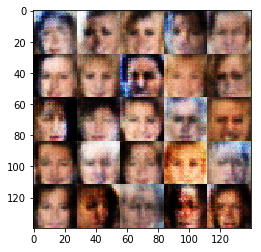

Epoch 1/1... Step: 810... Discriminator Loss: 1.0839... Generator Loss: 0.6664
Epoch 1/1... Step: 820... Discriminator Loss: 1.1860... Generator Loss: 0.6290
Epoch 1/1... Step: 830... Discriminator Loss: 1.4272... Generator Loss: 0.3438
Epoch 1/1... Step: 840... Discriminator Loss: 1.7219... Generator Loss: 0.2489
Epoch 1/1... Step: 850... Discriminator Loss: 0.9239... Generator Loss: 1.1750
Epoch 1/1... Step: 860... Discriminator Loss: 2.4668... Generator Loss: 0.1013
Epoch 1/1... Step: 870... Discriminator Loss: 0.8241... Generator Loss: 1.2200
Epoch 1/1... Step: 880... Discriminator Loss: 0.5392... Generator Loss: 1.6647
Epoch 1/1... Step: 890... Discriminator Loss: 1.6148... Generator Loss: 0.2821
Epoch 1/1... Step: 900... Discriminator Loss: 1.0157... Generator Loss: 1.0192
Cumulative Average Generator Loss / Discriminator Loss: 0.8367995023727417
Current Generator Loss / Discriminator Loss: 1.0034602880477905


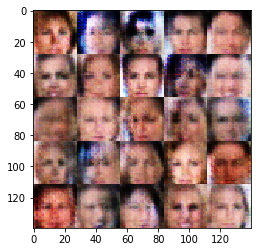

Epoch 1/1... Step: 910... Discriminator Loss: 0.8266... Generator Loss: 0.7230
Epoch 1/1... Step: 920... Discriminator Loss: 1.0286... Generator Loss: 1.2386
Epoch 1/1... Step: 930... Discriminator Loss: 1.0121... Generator Loss: 0.6073
Epoch 1/1... Step: 940... Discriminator Loss: 1.1960... Generator Loss: 0.4764
Epoch 1/1... Step: 950... Discriminator Loss: 0.8004... Generator Loss: 1.1133
Epoch 1/1... Step: 960... Discriminator Loss: 0.6818... Generator Loss: 1.5644
Epoch 1/1... Step: 970... Discriminator Loss: 1.3884... Generator Loss: 0.4230
Epoch 1/1... Step: 980... Discriminator Loss: 0.9013... Generator Loss: 1.5451
Epoch 1/1... Step: 990... Discriminator Loss: 1.4525... Generator Loss: 0.3355
Epoch 1/1... Step: 1000... Discriminator Loss: 0.7210... Generator Loss: 0.9369
Cumulative Average Generator Loss / Discriminator Loss: 0.841912567615509
Current Generator Loss / Discriminator Loss: 1.2995340824127197


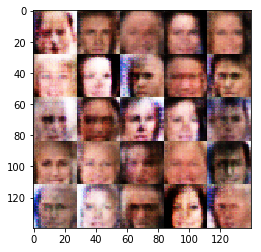

Epoch 1/1... Step: 1010... Discriminator Loss: 1.3080... Generator Loss: 2.3276
Epoch 1/1... Step: 1020... Discriminator Loss: 1.1375... Generator Loss: 0.6105
Epoch 1/1... Step: 1030... Discriminator Loss: 1.0243... Generator Loss: 0.6271
Epoch 1/1... Step: 1040... Discriminator Loss: 0.9755... Generator Loss: 0.6617
Epoch 1/1... Step: 1050... Discriminator Loss: 0.8466... Generator Loss: 1.2509
Epoch 1/1... Step: 1060... Discriminator Loss: 1.2069... Generator Loss: 2.0548
Epoch 1/1... Step: 1070... Discriminator Loss: 0.7434... Generator Loss: 1.1533
Epoch 1/1... Step: 1080... Discriminator Loss: 1.0791... Generator Loss: 0.6231
Epoch 1/1... Step: 1090... Discriminator Loss: 1.8735... Generator Loss: 0.2066
Epoch 1/1... Step: 1100... Discriminator Loss: 0.8610... Generator Loss: 0.7462
Cumulative Average Generator Loss / Discriminator Loss: 0.8494763374328613
Current Generator Loss / Discriminator Loss: 0.8666418194770813


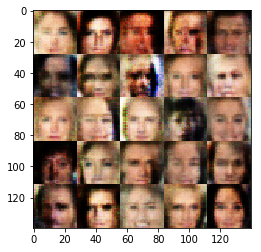

Epoch 1/1... Step: 1110... Discriminator Loss: 1.6234... Generator Loss: 0.2818
Epoch 1/1... Step: 1120... Discriminator Loss: 1.2826... Generator Loss: 0.4988
Epoch 1/1... Step: 1130... Discriminator Loss: 1.3796... Generator Loss: 0.3630
Epoch 1/1... Step: 1140... Discriminator Loss: 0.9565... Generator Loss: 0.9385
Epoch 1/1... Step: 1150... Discriminator Loss: 1.0819... Generator Loss: 0.7454
Epoch 1/1... Step: 1160... Discriminator Loss: 1.8459... Generator Loss: 0.2263
Epoch 1/1... Step: 1170... Discriminator Loss: 1.2404... Generator Loss: 2.3423
Epoch 1/1... Step: 1180... Discriminator Loss: 1.5943... Generator Loss: 0.2839
Epoch 1/1... Step: 1190... Discriminator Loss: 0.8466... Generator Loss: 1.1304
Epoch 1/1... Step: 1200... Discriminator Loss: 0.9549... Generator Loss: 0.6141
Cumulative Average Generator Loss / Discriminator Loss: 0.8246108889579773
Current Generator Loss / Discriminator Loss: 0.6431548595428467


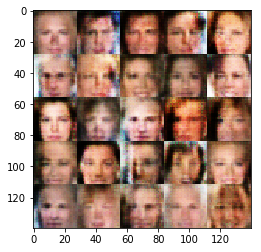

Epoch 1/1... Step: 1210... Discriminator Loss: 1.1213... Generator Loss: 1.0636
Epoch 1/1... Step: 1220... Discriminator Loss: 1.0202... Generator Loss: 0.7347
Epoch 1/1... Step: 1230... Discriminator Loss: 0.8847... Generator Loss: 0.8030
Epoch 1/1... Step: 1240... Discriminator Loss: 1.2410... Generator Loss: 0.7607
Epoch 1/1... Step: 1250... Discriminator Loss: 1.3076... Generator Loss: 0.4220
Epoch 1/1... Step: 1260... Discriminator Loss: 1.3554... Generator Loss: 0.4479
Epoch 1/1... Step: 1270... Discriminator Loss: 0.9081... Generator Loss: 2.1813
Epoch 1/1... Step: 1280... Discriminator Loss: 1.3541... Generator Loss: 0.5137
Epoch 1/1... Step: 1290... Discriminator Loss: 0.9097... Generator Loss: 0.8938
Epoch 1/1... Step: 1300... Discriminator Loss: 2.3632... Generator Loss: 0.1208
Cumulative Average Generator Loss / Discriminator Loss: 0.8091680407524109
Current Generator Loss / Discriminator Loss: 0.05110601335763931


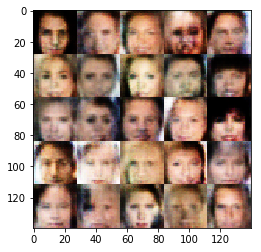

Epoch 1/1... Step: 1310... Discriminator Loss: 1.0877... Generator Loss: 1.0850
Epoch 1/1... Step: 1320... Discriminator Loss: 0.6550... Generator Loss: 2.2043
Epoch 1/1... Step: 1330... Discriminator Loss: 1.8386... Generator Loss: 0.2142
Epoch 1/1... Step: 1340... Discriminator Loss: 1.5472... Generator Loss: 0.3202
Epoch 1/1... Step: 1350... Discriminator Loss: 1.0194... Generator Loss: 1.0585
Epoch 1/1... Step: 1360... Discriminator Loss: 0.7949... Generator Loss: 0.8325
Epoch 1/1... Step: 1370... Discriminator Loss: 1.6474... Generator Loss: 0.2810
Epoch 1/1... Step: 1380... Discriminator Loss: 1.8921... Generator Loss: 0.2080
Epoch 1/1... Step: 1390... Discriminator Loss: 1.5372... Generator Loss: 0.2965
Epoch 1/1... Step: 1400... Discriminator Loss: 1.2959... Generator Loss: 1.3524
Cumulative Average Generator Loss / Discriminator Loss: 0.7914254665374756
Current Generator Loss / Discriminator Loss: 1.0435863733291626


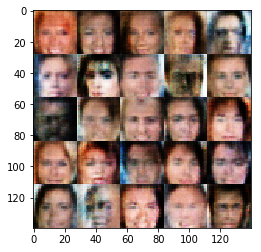

Epoch 1/1... Step: 1410... Discriminator Loss: 1.3876... Generator Loss: 0.3965
Epoch 1/1... Step: 1420... Discriminator Loss: 1.2470... Generator Loss: 0.5094
Epoch 1/1... Step: 1430... Discriminator Loss: 0.8291... Generator Loss: 0.7550
Epoch 1/1... Step: 1440... Discriminator Loss: 0.9562... Generator Loss: 0.9367
Epoch 1/1... Step: 1450... Discriminator Loss: 1.4459... Generator Loss: 0.4350
Epoch 1/1... Step: 1460... Discriminator Loss: 1.8246... Generator Loss: 0.2143
Epoch 1/1... Step: 1470... Discriminator Loss: 0.8999... Generator Loss: 0.7100
Epoch 1/1... Step: 1480... Discriminator Loss: 1.2500... Generator Loss: 0.5164
Epoch 1/1... Step: 1490... Discriminator Loss: 1.2618... Generator Loss: 0.6201
Epoch 1/1... Step: 1500... Discriminator Loss: 1.0192... Generator Loss: 0.9114
Cumulative Average Generator Loss / Discriminator Loss: 0.7711294889450073
Current Generator Loss / Discriminator Loss: 0.8942002654075623


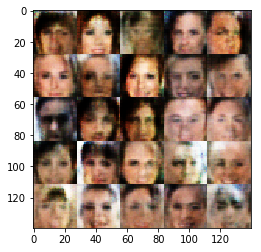

Epoch 1/1... Step: 1510... Discriminator Loss: 1.0165... Generator Loss: 0.6903
Epoch 1/1... Step: 1520... Discriminator Loss: 1.0432... Generator Loss: 0.5450
Epoch 1/1... Step: 1530... Discriminator Loss: 1.1867... Generator Loss: 0.6096
Epoch 1/1... Step: 1540... Discriminator Loss: 0.8637... Generator Loss: 1.0400
Epoch 1/1... Step: 1550... Discriminator Loss: 1.0255... Generator Loss: 0.7966
Epoch 1/1... Step: 1560... Discriminator Loss: 1.0745... Generator Loss: 0.8212
Epoch 1/1... Step: 1570... Discriminator Loss: 2.3311... Generator Loss: 3.0350
Epoch 1/1... Step: 1580... Discriminator Loss: 1.5108... Generator Loss: 0.3125
Epoch 1/1... Step: 1590... Discriminator Loss: 1.1006... Generator Loss: 0.7214
Epoch 1/1... Step: 1600... Discriminator Loss: 1.1688... Generator Loss: 0.5123
Cumulative Average Generator Loss / Discriminator Loss: 0.7689223885536194
Current Generator Loss / Discriminator Loss: 0.4382815659046173


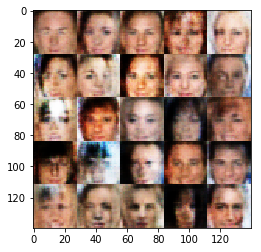

Epoch 1/1... Step: 1610... Discriminator Loss: 0.6235... Generator Loss: 1.2777
Epoch 1/1... Step: 1620... Discriminator Loss: 0.8342... Generator Loss: 1.0004
Epoch 1/1... Step: 1630... Discriminator Loss: 1.5698... Generator Loss: 0.2910
Epoch 1/1... Step: 1640... Discriminator Loss: 1.5616... Generator Loss: 0.3067
Epoch 1/1... Step: 1650... Discriminator Loss: 1.0747... Generator Loss: 0.5616
Epoch 1/1... Step: 1660... Discriminator Loss: 1.4488... Generator Loss: 0.3532
Epoch 1/1... Step: 1670... Discriminator Loss: 1.0076... Generator Loss: 1.6803
Epoch 1/1... Step: 1680... Discriminator Loss: 1.1048... Generator Loss: 0.6617
Epoch 1/1... Step: 1690... Discriminator Loss: 0.9259... Generator Loss: 1.3321
Epoch 1/1... Step: 1700... Discriminator Loss: 1.2392... Generator Loss: 0.4254
Cumulative Average Generator Loss / Discriminator Loss: 0.764594316482544
Current Generator Loss / Discriminator Loss: 0.3432917892932892


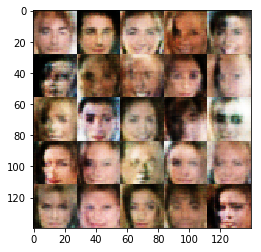

Epoch 1/1... Step: 1710... Discriminator Loss: 0.8591... Generator Loss: 0.9306
Epoch 1/1... Step: 1720... Discriminator Loss: 1.3668... Generator Loss: 0.4126
Epoch 1/1... Step: 1730... Discriminator Loss: 1.1529... Generator Loss: 0.4715
Epoch 1/1... Step: 1740... Discriminator Loss: 1.0517... Generator Loss: 0.6604
Epoch 1/1... Step: 1750... Discriminator Loss: 1.1033... Generator Loss: 1.4738
Epoch 1/1... Step: 1760... Discriminator Loss: 1.8662... Generator Loss: 0.1980
Epoch 1/1... Step: 1770... Discriminator Loss: 0.9315... Generator Loss: 1.1434
Epoch 1/1... Step: 1780... Discriminator Loss: 0.9240... Generator Loss: 1.1959
Epoch 1/1... Step: 1790... Discriminator Loss: 1.2363... Generator Loss: 0.4763
Epoch 1/1... Step: 1800... Discriminator Loss: 0.9766... Generator Loss: 0.6536
Cumulative Average Generator Loss / Discriminator Loss: 0.759156346321106
Current Generator Loss / Discriminator Loss: 0.6692386865615845


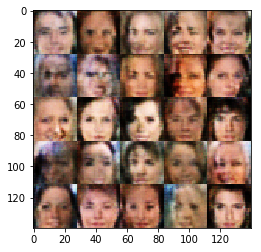

Epoch 1/1... Step: 1810... Discriminator Loss: 1.7285... Generator Loss: 0.2381
Epoch 1/1... Step: 1820... Discriminator Loss: 0.9203... Generator Loss: 0.8984
Epoch 1/1... Step: 1830... Discriminator Loss: 1.0296... Generator Loss: 0.7491
Epoch 1/1... Step: 1840... Discriminator Loss: 1.4123... Generator Loss: 0.3410
Epoch 1/1... Step: 1850... Discriminator Loss: 1.0257... Generator Loss: 0.7233
Epoch 1/1... Step: 1860... Discriminator Loss: 1.1446... Generator Loss: 0.4966
Epoch 1/1... Step: 1870... Discriminator Loss: 1.2348... Generator Loss: 0.4421
Epoch 1/1... Step: 1880... Discriminator Loss: 1.4433... Generator Loss: 0.3621
Epoch 1/1... Step: 1890... Discriminator Loss: 1.0285... Generator Loss: 0.5598
Epoch 1/1... Step: 1900... Discriminator Loss: 0.9067... Generator Loss: 1.2076
Cumulative Average Generator Loss / Discriminator Loss: 0.7457714676856995
Current Generator Loss / Discriminator Loss: 1.3319215774536133


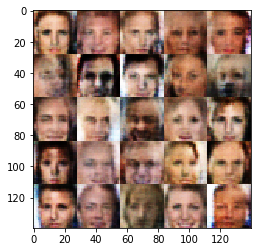

Epoch 1/1... Step: 1910... Discriminator Loss: 1.0575... Generator Loss: 1.5550
Epoch 1/1... Step: 1920... Discriminator Loss: 0.9662... Generator Loss: 0.6266
Epoch 1/1... Step: 1930... Discriminator Loss: 1.0133... Generator Loss: 0.6509
Epoch 1/1... Step: 1940... Discriminator Loss: 1.3105... Generator Loss: 0.4589
Epoch 1/1... Step: 1950... Discriminator Loss: 1.0977... Generator Loss: 1.4428
Epoch 1/1... Step: 1960... Discriminator Loss: 0.8123... Generator Loss: 0.9318
Epoch 1/1... Step: 1970... Discriminator Loss: 0.9480... Generator Loss: 0.9270
Epoch 1/1... Step: 1980... Discriminator Loss: 1.2323... Generator Loss: 0.4559
Epoch 1/1... Step: 1990... Discriminator Loss: 1.6050... Generator Loss: 0.2741
Epoch 1/1... Step: 2000... Discriminator Loss: 0.8275... Generator Loss: 1.1956
Cumulative Average Generator Loss / Discriminator Loss: 0.7475254535675049
Current Generator Loss / Discriminator Loss: 1.44490385055542


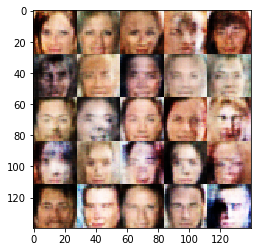

Epoch 1/1... Step: 2010... Discriminator Loss: 0.9089... Generator Loss: 0.8250
Epoch 1/1... Step: 2020... Discriminator Loss: 0.8892... Generator Loss: 1.2400
Epoch 1/1... Step: 2030... Discriminator Loss: 2.0268... Generator Loss: 0.1762
Epoch 1/1... Step: 2040... Discriminator Loss: 1.2786... Generator Loss: 0.4692
Epoch 1/1... Step: 2050... Discriminator Loss: 1.3379... Generator Loss: 0.3870
Epoch 1/1... Step: 2060... Discriminator Loss: 1.2351... Generator Loss: 0.5447
Epoch 1/1... Step: 2070... Discriminator Loss: 0.8628... Generator Loss: 0.7593
Epoch 1/1... Step: 2080... Discriminator Loss: 1.6415... Generator Loss: 0.2792
Epoch 1/1... Step: 2090... Discriminator Loss: 0.9531... Generator Loss: 0.7637
Epoch 1/1... Step: 2100... Discriminator Loss: 1.4983... Generator Loss: 0.3160
Cumulative Average Generator Loss / Discriminator Loss: 0.7326377630233765
Current Generator Loss / Discriminator Loss: 0.21094253659248352


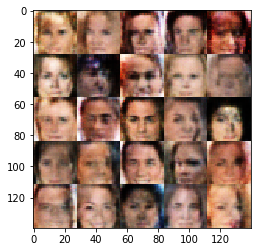

Epoch 1/1... Step: 2110... Discriminator Loss: 1.4204... Generator Loss: 0.4113
Epoch 1/1... Step: 2120... Discriminator Loss: 1.4399... Generator Loss: 0.3940
Epoch 1/1... Step: 2130... Discriminator Loss: 0.7811... Generator Loss: 1.9363
Epoch 1/1... Step: 2140... Discriminator Loss: 1.4550... Generator Loss: 0.3611
Epoch 1/1... Step: 2150... Discriminator Loss: 0.8710... Generator Loss: 1.1804
Epoch 1/1... Step: 2160... Discriminator Loss: 1.4088... Generator Loss: 0.4420
Epoch 1/1... Step: 2170... Discriminator Loss: 1.0592... Generator Loss: 0.6759
Epoch 1/1... Step: 2180... Discriminator Loss: 1.7757... Generator Loss: 0.2268
Epoch 1/1... Step: 2190... Discriminator Loss: 1.4941... Generator Loss: 0.3342
Epoch 1/1... Step: 2200... Discriminator Loss: 0.7088... Generator Loss: 1.4235
Cumulative Average Generator Loss / Discriminator Loss: 0.7260569930076599
Current Generator Loss / Discriminator Loss: 2.0083301067352295


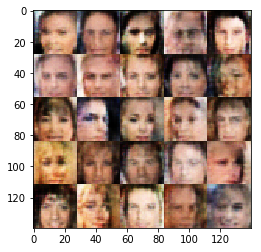

Epoch 1/1... Step: 2210... Discriminator Loss: 2.0072... Generator Loss: 0.1881
Epoch 1/1... Step: 2220... Discriminator Loss: 1.1291... Generator Loss: 0.8570
Epoch 1/1... Step: 2230... Discriminator Loss: 2.0610... Generator Loss: 0.1652
Epoch 1/1... Step: 2240... Discriminator Loss: 0.7262... Generator Loss: 1.0287
Epoch 1/1... Step: 2250... Discriminator Loss: 1.0070... Generator Loss: 0.8082
Epoch 1/1... Step: 2260... Discriminator Loss: 1.0159... Generator Loss: 0.7805
Epoch 1/1... Step: 2270... Discriminator Loss: 0.9368... Generator Loss: 0.7029
Epoch 1/1... Step: 2280... Discriminator Loss: 1.6271... Generator Loss: 0.2787
Epoch 1/1... Step: 2290... Discriminator Loss: 1.3077... Generator Loss: 2.2638
Epoch 1/1... Step: 2300... Discriminator Loss: 1.1831... Generator Loss: 0.6197
Cumulative Average Generator Loss / Discriminator Loss: 0.7196533679962158
Current Generator Loss / Discriminator Loss: 0.523796558380127


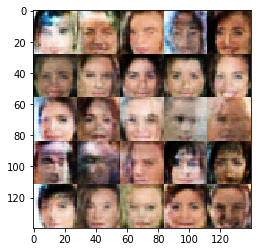

Epoch 1/1... Step: 2310... Discriminator Loss: 1.0519... Generator Loss: 0.5848
Epoch 1/1... Step: 2320... Discriminator Loss: 1.2317... Generator Loss: 0.4668
Epoch 1/1... Step: 2330... Discriminator Loss: 1.7714... Generator Loss: 0.2298
Epoch 1/1... Step: 2340... Discriminator Loss: 2.1169... Generator Loss: 0.1463
Epoch 1/1... Step: 2350... Discriminator Loss: 1.0790... Generator Loss: 1.8315
Epoch 1/1... Step: 2360... Discriminator Loss: 1.0062... Generator Loss: 0.5689
Epoch 1/1... Step: 2370... Discriminator Loss: 1.9662... Generator Loss: 0.1864
Epoch 1/1... Step: 2380... Discriminator Loss: 1.1669... Generator Loss: 0.6069
Epoch 1/1... Step: 2390... Discriminator Loss: 0.9739... Generator Loss: 0.6250
Epoch 1/1... Step: 2400... Discriminator Loss: 1.0547... Generator Loss: 0.9508
Cumulative Average Generator Loss / Discriminator Loss: 0.7075647711753845
Current Generator Loss / Discriminator Loss: 0.9015138149261475


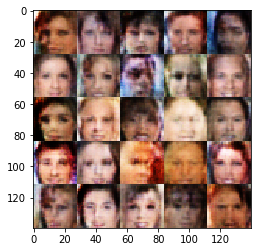

Epoch 1/1... Step: 2410... Discriminator Loss: 1.2150... Generator Loss: 0.5315
Epoch 1/1... Step: 2420... Discriminator Loss: 1.3647... Generator Loss: 0.4371
Epoch 1/1... Step: 2430... Discriminator Loss: 1.5037... Generator Loss: 0.3436
Epoch 1/1... Step: 2440... Discriminator Loss: 1.0846... Generator Loss: 0.8481
Epoch 1/1... Step: 2450... Discriminator Loss: 0.8734... Generator Loss: 1.0225
Epoch 1/1... Step: 2460... Discriminator Loss: 0.8111... Generator Loss: 0.8470
Epoch 1/1... Step: 2470... Discriminator Loss: 1.1072... Generator Loss: 0.6319
Epoch 1/1... Step: 2480... Discriminator Loss: 0.7885... Generator Loss: 0.9219
Epoch 1/1... Step: 2490... Discriminator Loss: 1.8382... Generator Loss: 0.2165
Epoch 1/1... Step: 2500... Discriminator Loss: 0.9767... Generator Loss: 0.9072
Cumulative Average Generator Loss / Discriminator Loss: 0.7026129961013794
Current Generator Loss / Discriminator Loss: 0.9288581609725952


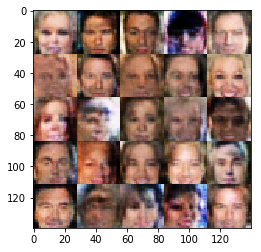

Epoch 1/1... Step: 2510... Discriminator Loss: 1.3821... Generator Loss: 0.3673
Epoch 1/1... Step: 2520... Discriminator Loss: 1.5525... Generator Loss: 0.3026
Epoch 1/1... Step: 2530... Discriminator Loss: 0.7626... Generator Loss: 0.8144
Epoch 1/1... Step: 2540... Discriminator Loss: 1.3586... Generator Loss: 2.0040
Epoch 1/1... Step: 2550... Discriminator Loss: 1.1808... Generator Loss: 0.5231
Epoch 1/1... Step: 2560... Discriminator Loss: 1.0137... Generator Loss: 0.9643
Epoch 1/1... Step: 2570... Discriminator Loss: 1.3543... Generator Loss: 0.4249
Epoch 1/1... Step: 2580... Discriminator Loss: 1.6589... Generator Loss: 0.2810
Epoch 1/1... Step: 2590... Discriminator Loss: 1.3255... Generator Loss: 0.4316
Epoch 1/1... Step: 2600... Discriminator Loss: 0.8579... Generator Loss: 1.9191
Cumulative Average Generator Loss / Discriminator Loss: 0.700314998626709
Current Generator Loss / Discriminator Loss: 2.2371158599853516


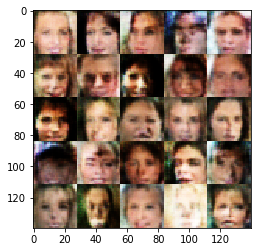

Epoch 1/1... Step: 2610... Discriminator Loss: 1.4444... Generator Loss: 0.3898
Epoch 1/1... Step: 2620... Discriminator Loss: 1.5083... Generator Loss: 0.3073
Epoch 1/1... Step: 2630... Discriminator Loss: 2.3240... Generator Loss: 0.1172
Epoch 1/1... Step: 2640... Discriminator Loss: 0.8548... Generator Loss: 1.0594
Epoch 1/1... Step: 2650... Discriminator Loss: 1.3132... Generator Loss: 0.4597
Epoch 1/1... Step: 2660... Discriminator Loss: 1.2474... Generator Loss: 0.5017
Epoch 1/1... Step: 2670... Discriminator Loss: 1.4304... Generator Loss: 0.4037
Epoch 1/1... Step: 2680... Discriminator Loss: 0.6549... Generator Loss: 1.0892
Epoch 1/1... Step: 2690... Discriminator Loss: 0.9005... Generator Loss: 0.7890
Epoch 1/1... Step: 2700... Discriminator Loss: 1.5631... Generator Loss: 0.3018
Cumulative Average Generator Loss / Discriminator Loss: 0.6883993148803711
Current Generator Loss / Discriminator Loss: 0.19309723377227783


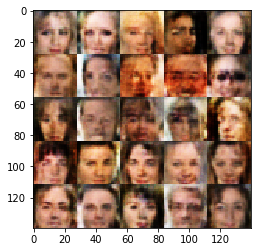

Epoch 1/1... Step: 2710... Discriminator Loss: 1.1371... Generator Loss: 0.9147
Epoch 1/1... Step: 2720... Discriminator Loss: 1.2600... Generator Loss: 0.4088
Epoch 1/1... Step: 2730... Discriminator Loss: 1.7536... Generator Loss: 0.3084
Epoch 1/1... Step: 2740... Discriminator Loss: 1.3182... Generator Loss: 0.3736
Epoch 1/1... Step: 2750... Discriminator Loss: 1.5703... Generator Loss: 0.2881
Epoch 1/1... Step: 2760... Discriminator Loss: 0.7288... Generator Loss: 0.8838
Epoch 1/1... Step: 2770... Discriminator Loss: 1.3895... Generator Loss: 0.4071
Epoch 1/1... Step: 2780... Discriminator Loss: 1.0367... Generator Loss: 0.8714
Epoch 1/1... Step: 2790... Discriminator Loss: 1.1985... Generator Loss: 0.4704
Epoch 1/1... Step: 2800... Discriminator Loss: 0.7034... Generator Loss: 1.0354
Cumulative Average Generator Loss / Discriminator Loss: 0.6813495755195618
Current Generator Loss / Discriminator Loss: 1.471957802772522


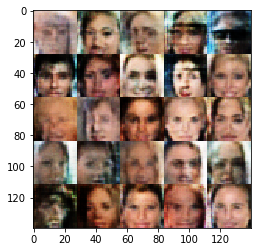

Epoch 1/1... Step: 2810... Discriminator Loss: 1.4652... Generator Loss: 0.3552
Epoch 1/1... Step: 2820... Discriminator Loss: 1.0822... Generator Loss: 0.5453
Epoch 1/1... Step: 2830... Discriminator Loss: 1.0223... Generator Loss: 0.7224
Epoch 1/1... Step: 2840... Discriminator Loss: 1.6867... Generator Loss: 0.2546
Epoch 1/1... Step: 2850... Discriminator Loss: 1.7576... Generator Loss: 0.2528
Epoch 1/1... Step: 2860... Discriminator Loss: 1.7510... Generator Loss: 0.2175
Epoch 1/1... Step: 2870... Discriminator Loss: 1.3943... Generator Loss: 0.3853
Epoch 1/1... Step: 2880... Discriminator Loss: 1.1417... Generator Loss: 1.2958
Epoch 1/1... Step: 2890... Discriminator Loss: 1.3803... Generator Loss: 0.3682
Epoch 1/1... Step: 2900... Discriminator Loss: 1.4999... Generator Loss: 0.3189
Cumulative Average Generator Loss / Discriminator Loss: 0.6672058701515198
Current Generator Loss / Discriminator Loss: 0.21258996427059174


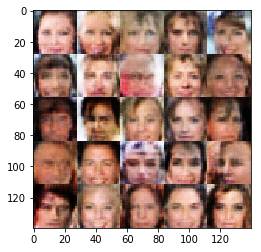

Epoch 1/1... Step: 2910... Discriminator Loss: 1.1574... Generator Loss: 0.5415
Epoch 1/1... Step: 2920... Discriminator Loss: 1.4865... Generator Loss: 0.3356
Epoch 1/1... Step: 2930... Discriminator Loss: 1.4156... Generator Loss: 0.3504
Epoch 1/1... Step: 2940... Discriminator Loss: 1.4863... Generator Loss: 0.3541
Epoch 1/1... Step: 2950... Discriminator Loss: 0.9374... Generator Loss: 0.7209
Epoch 1/1... Step: 2960... Discriminator Loss: 1.3596... Generator Loss: 1.0950
Epoch 1/1... Step: 2970... Discriminator Loss: 1.5164... Generator Loss: 0.3082
Epoch 1/1... Step: 2980... Discriminator Loss: 1.3601... Generator Loss: 0.5118
Epoch 1/1... Step: 2990... Discriminator Loss: 1.2055... Generator Loss: 0.5185
Epoch 1/1... Step: 3000... Discriminator Loss: 1.2667... Generator Loss: 0.4052
Cumulative Average Generator Loss / Discriminator Loss: 0.6571205854415894
Current Generator Loss / Discriminator Loss: 0.31991344690322876


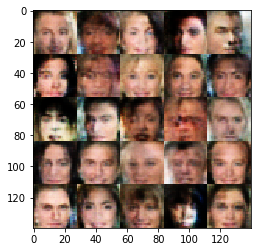

Epoch 1/1... Step: 3010... Discriminator Loss: 1.0903... Generator Loss: 0.5306
Epoch 1/1... Step: 3020... Discriminator Loss: 2.1981... Generator Loss: 0.1623
Epoch 1/1... Step: 3030... Discriminator Loss: 1.9826... Generator Loss: 0.1899
Epoch 1/1... Step: 3040... Discriminator Loss: 1.4481... Generator Loss: 0.3874
Epoch 1/1... Step: 3050... Discriminator Loss: 1.5269... Generator Loss: 0.3151
Epoch 1/1... Step: 3060... Discriminator Loss: 0.8855... Generator Loss: 0.6643
Epoch 1/1... Step: 3070... Discriminator Loss: 1.4501... Generator Loss: 2.3580
Epoch 1/1... Step: 3080... Discriminator Loss: 1.5172... Generator Loss: 0.3278
Epoch 1/1... Step: 3090... Discriminator Loss: 0.9632... Generator Loss: 1.0313
Epoch 1/1... Step: 3100... Discriminator Loss: 2.2484... Generator Loss: 0.1652
Cumulative Average Generator Loss / Discriminator Loss: 0.6467328071594238
Current Generator Loss / Discriminator Loss: 0.07347486168146133


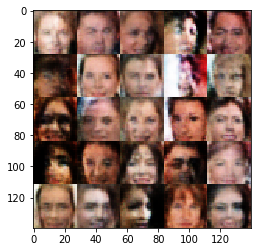

Epoch 1/1... Step: 3110... Discriminator Loss: 1.2322... Generator Loss: 0.5117
Epoch 1/1... Step: 3120... Discriminator Loss: 0.8739... Generator Loss: 0.6877
Epoch 1/1... Step: 3130... Discriminator Loss: 1.6650... Generator Loss: 0.2645
Epoch 1/1... Step: 3140... Discriminator Loss: 1.2959... Generator Loss: 0.4368
Epoch 1/1... Step: 3150... Discriminator Loss: 1.2839... Generator Loss: 0.4821
Epoch 1/1... Step: 3160... Discriminator Loss: 0.9831... Generator Loss: 0.9790
Epoch 1/1... Step: 3170... Discriminator Loss: 1.2365... Generator Loss: 0.6735
Epoch 1/1... Step: 3180... Discriminator Loss: 2.0079... Generator Loss: 0.1771
Epoch 1/1... Step: 3190... Discriminator Loss: 1.4654... Generator Loss: 0.3356
Epoch 1/1... Step: 3200... Discriminator Loss: 0.8865... Generator Loss: 0.8078
Cumulative Average Generator Loss / Discriminator Loss: 0.6390460729598999
Current Generator Loss / Discriminator Loss: 0.9112645983695984


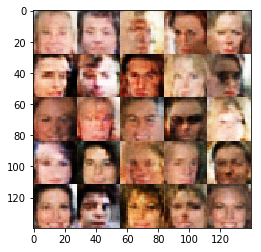

Epoch 1/1... Step: 3210... Discriminator Loss: 2.2832... Generator Loss: 0.1405
Epoch 1/1... Step: 3220... Discriminator Loss: 1.1764... Generator Loss: 0.5400
Epoch 1/1... Step: 3230... Discriminator Loss: 0.8915... Generator Loss: 0.8793
Epoch 1/1... Step: 3240... Discriminator Loss: 0.9546... Generator Loss: 0.7552
Epoch 1/1... Step: 3250... Discriminator Loss: 1.0849... Generator Loss: 0.7130
Epoch 1/1... Step: 3260... Discriminator Loss: 1.3999... Generator Loss: 0.3421
Epoch 1/1... Step: 3270... Discriminator Loss: 0.9474... Generator Loss: 0.9776
Epoch 1/1... Step: 3280... Discriminator Loss: 2.1920... Generator Loss: 0.1380
Epoch 1/1... Step: 3290... Discriminator Loss: 0.7935... Generator Loss: 1.0571
Epoch 1/1... Step: 3300... Discriminator Loss: 1.4453... Generator Loss: 0.3314
Cumulative Average Generator Loss / Discriminator Loss: 0.6327609419822693
Current Generator Loss / Discriminator Loss: 0.229275643825531


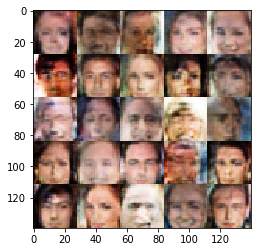

Epoch 1/1... Step: 3310... Discriminator Loss: 1.3942... Generator Loss: 0.4857
Epoch 1/1... Step: 3320... Discriminator Loss: 0.7862... Generator Loss: 1.4692
Epoch 1/1... Step: 3330... Discriminator Loss: 1.6853... Generator Loss: 0.2502
Epoch 1/1... Step: 3340... Discriminator Loss: 1.2777... Generator Loss: 0.4307
Epoch 1/1... Step: 3350... Discriminator Loss: 1.0929... Generator Loss: 0.6391
Epoch 1/1... Step: 3360... Discriminator Loss: 1.5008... Generator Loss: 0.3173
Epoch 1/1... Step: 3370... Discriminator Loss: 1.6422... Generator Loss: 0.2454
Epoch 1/1... Step: 3380... Discriminator Loss: 0.7728... Generator Loss: 1.2194
Epoch 1/1... Step: 3390... Discriminator Loss: 1.1611... Generator Loss: 0.5894
Epoch 1/1... Step: 3400... Discriminator Loss: 1.2931... Generator Loss: 0.4463
Cumulative Average Generator Loss / Discriminator Loss: 0.6282419562339783
Current Generator Loss / Discriminator Loss: 0.34514665603637695


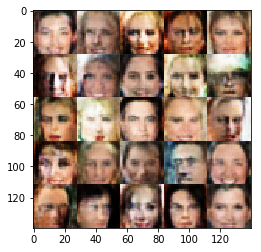

Epoch 1/1... Step: 3410... Discriminator Loss: 0.9554... Generator Loss: 1.2559
Epoch 1/1... Step: 3420... Discriminator Loss: 1.4379... Generator Loss: 0.3244
Epoch 1/1... Step: 3430... Discriminator Loss: 0.5207... Generator Loss: 1.2361
Epoch 1/1... Step: 3440... Discriminator Loss: 0.9729... Generator Loss: 0.7867
Epoch 1/1... Step: 3450... Discriminator Loss: 1.1637... Generator Loss: 0.4913
Epoch 1/1... Step: 3460... Discriminator Loss: 1.3135... Generator Loss: 0.4553
Epoch 1/1... Step: 3470... Discriminator Loss: 1.8315... Generator Loss: 0.2238
Epoch 1/1... Step: 3480... Discriminator Loss: 2.3041... Generator Loss: 0.1326
Epoch 1/1... Step: 3490... Discriminator Loss: 1.2686... Generator Loss: 0.4087
Epoch 1/1... Step: 3500... Discriminator Loss: 1.1650... Generator Loss: 0.5845
Cumulative Average Generator Loss / Discriminator Loss: 0.6230631470680237
Current Generator Loss / Discriminator Loss: 0.5017165541648865


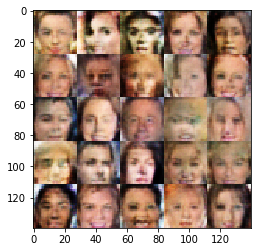

Epoch 1/1... Step: 3510... Discriminator Loss: 1.2976... Generator Loss: 0.4755
Epoch 1/1... Step: 3520... Discriminator Loss: 1.4707... Generator Loss: 0.4373
Epoch 1/1... Step: 3530... Discriminator Loss: 1.7685... Generator Loss: 0.2270
Epoch 1/1... Step: 3540... Discriminator Loss: 0.7625... Generator Loss: 1.2242
Epoch 1/1... Step: 3550... Discriminator Loss: 0.8646... Generator Loss: 2.0383
Epoch 1/1... Step: 3560... Discriminator Loss: 1.4995... Generator Loss: 0.3202
Epoch 1/1... Step: 3570... Discriminator Loss: 1.1258... Generator Loss: 1.2970
Epoch 1/1... Step: 3580... Discriminator Loss: 1.0899... Generator Loss: 0.6504
Epoch 1/1... Step: 3590... Discriminator Loss: 1.4272... Generator Loss: 0.3928
Epoch 1/1... Step: 3600... Discriminator Loss: 1.3280... Generator Loss: 0.4240
Cumulative Average Generator Loss / Discriminator Loss: 0.6221924424171448
Current Generator Loss / Discriminator Loss: 0.31928467750549316


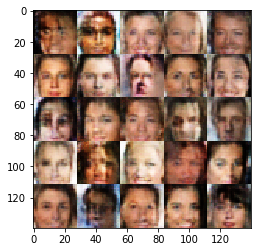

Epoch 1/1... Step: 3610... Discriminator Loss: 1.0941... Generator Loss: 0.6374
Epoch 1/1... Step: 3620... Discriminator Loss: 0.9440... Generator Loss: 1.7206
Epoch 1/1... Step: 3630... Discriminator Loss: 0.8227... Generator Loss: 1.2969
Epoch 1/1... Step: 3640... Discriminator Loss: 1.3806... Generator Loss: 0.3929
Epoch 1/1... Step: 3650... Discriminator Loss: 1.5475... Generator Loss: 0.2996
Epoch 1/1... Step: 3660... Discriminator Loss: 1.3084... Generator Loss: 0.4512
Epoch 1/1... Step: 3670... Discriminator Loss: 0.7749... Generator Loss: 1.0476
Epoch 1/1... Step: 3680... Discriminator Loss: 0.5802... Generator Loss: 1.8104
Epoch 1/1... Step: 3690... Discriminator Loss: 1.2491... Generator Loss: 0.4839
Epoch 1/1... Step: 3700... Discriminator Loss: 1.7248... Generator Loss: 0.2495
Cumulative Average Generator Loss / Discriminator Loss: 0.6250138878822327
Current Generator Loss / Discriminator Loss: 0.14464637637138367


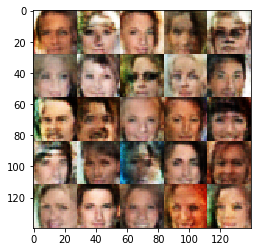

Epoch 1/1... Step: 3710... Discriminator Loss: 1.4414... Generator Loss: 0.4087
Epoch 1/1... Step: 3720... Discriminator Loss: 1.5798... Generator Loss: 0.3439
Epoch 1/1... Step: 3730... Discriminator Loss: 1.7388... Generator Loss: 0.2304
Epoch 1/1... Step: 3740... Discriminator Loss: 1.4716... Generator Loss: 0.3946
Epoch 1/1... Step: 3750... Discriminator Loss: 1.2849... Generator Loss: 0.4317
Epoch 1/1... Step: 3760... Discriminator Loss: 0.9319... Generator Loss: 0.8138
Epoch 1/1... Step: 3770... Discriminator Loss: 0.8694... Generator Loss: 0.8367
Epoch 1/1... Step: 3780... Discriminator Loss: 1.0364... Generator Loss: 0.6156
Epoch 1/1... Step: 3790... Discriminator Loss: 1.5081... Generator Loss: 0.3226
Epoch 1/1... Step: 3800... Discriminator Loss: 1.1382... Generator Loss: 0.6873
Cumulative Average Generator Loss / Discriminator Loss: 0.6185028553009033
Current Generator Loss / Discriminator Loss: 0.6038752794265747


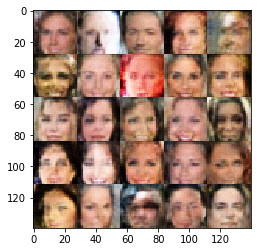

Epoch 1/1... Step: 3810... Discriminator Loss: 1.2096... Generator Loss: 0.4649
Epoch 1/1... Step: 3820... Discriminator Loss: 1.0773... Generator Loss: 0.8022
Epoch 1/1... Step: 3830... Discriminator Loss: 0.9540... Generator Loss: 0.7654
Epoch 1/1... Step: 3840... Discriminator Loss: 2.3298... Generator Loss: 0.1248
Epoch 1/1... Step: 3850... Discriminator Loss: 0.8954... Generator Loss: 1.3284
Epoch 1/1... Step: 3860... Discriminator Loss: 1.7726... Generator Loss: 0.2189
Epoch 1/1... Step: 3870... Discriminator Loss: 1.6725... Generator Loss: 0.2575
Epoch 1/1... Step: 3880... Discriminator Loss: 1.0913... Generator Loss: 0.9738
Epoch 1/1... Step: 3890... Discriminator Loss: 1.0803... Generator Loss: 0.6409
Epoch 1/1... Step: 3900... Discriminator Loss: 1.6219... Generator Loss: 0.2582
Cumulative Average Generator Loss / Discriminator Loss: 0.6130072474479675
Current Generator Loss / Discriminator Loss: 0.15920156240463257


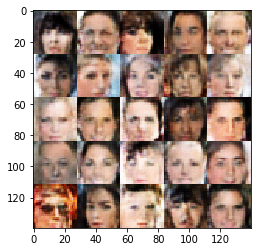

Epoch 1/1... Step: 3910... Discriminator Loss: 1.8150... Generator Loss: 0.2053
Epoch 1/1... Step: 3920... Discriminator Loss: 0.9888... Generator Loss: 0.9745
Epoch 1/1... Step: 3930... Discriminator Loss: 0.9460... Generator Loss: 0.7168
Epoch 1/1... Step: 3940... Discriminator Loss: 1.0964... Generator Loss: 2.5054
Epoch 1/1... Step: 3950... Discriminator Loss: 1.2156... Generator Loss: 0.4391
Epoch 1/1... Step: 3960... Discriminator Loss: 2.1683... Generator Loss: 0.1437
Epoch 1/1... Step: 3970... Discriminator Loss: 1.9436... Generator Loss: 0.1956
Epoch 1/1... Step: 3980... Discriminator Loss: 1.3060... Generator Loss: 0.5399
Epoch 1/1... Step: 3990... Discriminator Loss: 1.2728... Generator Loss: 0.4120
Epoch 1/1... Step: 4000... Discriminator Loss: 1.4952... Generator Loss: 0.3779
Cumulative Average Generator Loss / Discriminator Loss: 0.6085138320922852
Current Generator Loss / Discriminator Loss: 0.2527347505092621


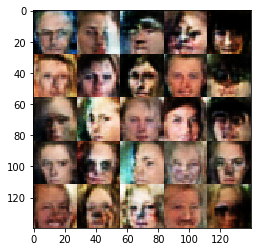

Epoch 1/1... Step: 4010... Discriminator Loss: 1.2081... Generator Loss: 0.5094
Epoch 1/1... Step: 4020... Discriminator Loss: 0.8634... Generator Loss: 0.8847
Epoch 1/1... Step: 4030... Discriminator Loss: 1.2687... Generator Loss: 0.4441
Epoch 1/1... Step: 4040... Discriminator Loss: 1.0194... Generator Loss: 0.6080
Epoch 1/1... Step: 4050... Discriminator Loss: 1.6888... Generator Loss: 0.2623
Epoch 1/1... Step: 4060... Discriminator Loss: 1.3166... Generator Loss: 0.3858
Epoch 1/1... Step: 4070... Discriminator Loss: 1.1667... Generator Loss: 0.4966
Epoch 1/1... Step: 4080... Discriminator Loss: 1.6510... Generator Loss: 0.2747
Epoch 1/1... Step: 4090... Discriminator Loss: 1.5084... Generator Loss: 0.3428
Epoch 1/1... Step: 4100... Discriminator Loss: 1.5964... Generator Loss: 0.2799
Cumulative Average Generator Loss / Discriminator Loss: 0.6014347076416016
Current Generator Loss / Discriminator Loss: 0.1753114014863968


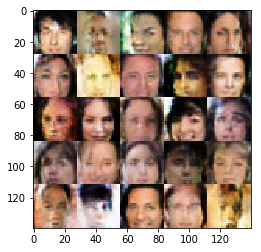

Epoch 1/1... Step: 4110... Discriminator Loss: 0.7244... Generator Loss: 1.3379
Epoch 1/1... Step: 4120... Discriminator Loss: 0.9930... Generator Loss: 0.6442
Epoch 1/1... Step: 4130... Discriminator Loss: 1.6470... Generator Loss: 0.2924
Epoch 1/1... Step: 4140... Discriminator Loss: 1.3005... Generator Loss: 0.6384
Epoch 1/1... Step: 4150... Discriminator Loss: 1.2703... Generator Loss: 0.4075
Epoch 1/1... Step: 4160... Discriminator Loss: 0.6434... Generator Loss: 1.1938
Epoch 1/1... Step: 4170... Discriminator Loss: 1.5074... Generator Loss: 0.3057
Epoch 1/1... Step: 4180... Discriminator Loss: 1.8051... Generator Loss: 0.2298
Epoch 1/1... Step: 4190... Discriminator Loss: 1.8328... Generator Loss: 0.2045
Epoch 1/1... Step: 4200... Discriminator Loss: 1.4900... Generator Loss: 0.3409
Cumulative Average Generator Loss / Discriminator Loss: 0.5969231128692627
Current Generator Loss / Discriminator Loss: 0.22879503667354584


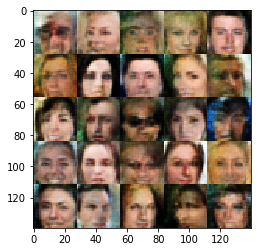

Epoch 1/1... Step: 4210... Discriminator Loss: 1.9640... Generator Loss: 0.1910
Epoch 1/1... Step: 4220... Discriminator Loss: 1.2452... Generator Loss: 0.5287
Epoch 1/1... Step: 4230... Discriminator Loss: 1.0859... Generator Loss: 0.5968
Epoch 1/1... Step: 4240... Discriminator Loss: 1.1040... Generator Loss: 0.6258
Epoch 1/1... Step: 4250... Discriminator Loss: 2.2161... Generator Loss: 0.1408
Epoch 1/1... Step: 4260... Discriminator Loss: 1.0324... Generator Loss: 1.2727
Epoch 1/1... Step: 4270... Discriminator Loss: 1.5132... Generator Loss: 0.3275
Epoch 1/1... Step: 4280... Discriminator Loss: 1.2219... Generator Loss: 1.2132
Epoch 1/1... Step: 4290... Discriminator Loss: 1.7111... Generator Loss: 0.2517
Epoch 1/1... Step: 4300... Discriminator Loss: 1.2041... Generator Loss: 0.5418
Cumulative Average Generator Loss / Discriminator Loss: 0.5916124582290649
Current Generator Loss / Discriminator Loss: 0.4499225914478302


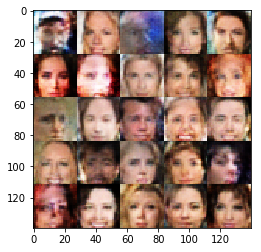

Epoch 1/1... Step: 4310... Discriminator Loss: 1.2678... Generator Loss: 0.5322
Epoch 1/1... Step: 4320... Discriminator Loss: 0.9027... Generator Loss: 0.8606
Epoch 1/1... Step: 4330... Discriminator Loss: 0.7667... Generator Loss: 0.8752
Epoch 1/1... Step: 4340... Discriminator Loss: 0.8476... Generator Loss: 1.1583
Epoch 1/1... Step: 4350... Discriminator Loss: 1.8064... Generator Loss: 0.2247
Epoch 1/1... Step: 4360... Discriminator Loss: 1.8273... Generator Loss: 0.2369
Epoch 1/1... Step: 4370... Discriminator Loss: 1.1018... Generator Loss: 0.5401
Epoch 1/1... Step: 4380... Discriminator Loss: 2.4248... Generator Loss: 0.1080
Epoch 1/1... Step: 4390... Discriminator Loss: 1.4297... Generator Loss: 0.3673
Epoch 1/1... Step: 4400... Discriminator Loss: 1.4288... Generator Loss: 0.4085
Cumulative Average Generator Loss / Discriminator Loss: 0.5864174962043762
Current Generator Loss / Discriminator Loss: 0.2859368920326233


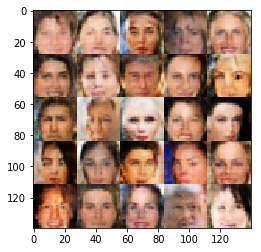

Epoch 1/1... Step: 4410... Discriminator Loss: 1.9937... Generator Loss: 0.2018
Epoch 1/1... Step: 4420... Discriminator Loss: 1.8795... Generator Loss: 0.2225
Epoch 1/1... Step: 4430... Discriminator Loss: 1.4346... Generator Loss: 0.4172
Epoch 1/1... Step: 4440... Discriminator Loss: 1.3453... Generator Loss: 0.4437
Epoch 1/1... Step: 4450... Discriminator Loss: 1.2349... Generator Loss: 0.4625
Epoch 1/1... Step: 4460... Discriminator Loss: 1.1101... Generator Loss: 0.4851
Epoch 1/1... Step: 4470... Discriminator Loss: 1.0861... Generator Loss: 0.7611
Epoch 1/1... Step: 4480... Discriminator Loss: 1.7262... Generator Loss: 0.2444
Epoch 1/1... Step: 4490... Discriminator Loss: 2.1177... Generator Loss: 0.1678
Epoch 1/1... Step: 4500... Discriminator Loss: 1.2509... Generator Loss: 0.4700
Cumulative Average Generator Loss / Discriminator Loss: 0.5775179266929626
Current Generator Loss / Discriminator Loss: 0.3757593631744385


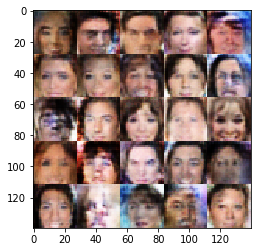

Epoch 1/1... Step: 4510... Discriminator Loss: 0.7766... Generator Loss: 0.9084
Epoch 1/1... Step: 4520... Discriminator Loss: 1.3334... Generator Loss: 0.4317
Epoch 1/1... Step: 4530... Discriminator Loss: 1.4526... Generator Loss: 0.3580
Epoch 1/1... Step: 4540... Discriminator Loss: 1.0725... Generator Loss: 0.9472
Epoch 1/1... Step: 4550... Discriminator Loss: 0.8913... Generator Loss: 0.6923
Epoch 1/1... Step: 4560... Discriminator Loss: 1.2177... Generator Loss: 0.5068
Epoch 1/1... Step: 4570... Discriminator Loss: 1.4377... Generator Loss: 0.3786
Epoch 1/1... Step: 4580... Discriminator Loss: 1.8784... Generator Loss: 0.2200
Epoch 1/1... Step: 4590... Discriminator Loss: 1.1641... Generator Loss: 0.7753
Epoch 1/1... Step: 4600... Discriminator Loss: 1.4131... Generator Loss: 0.4076
Cumulative Average Generator Loss / Discriminator Loss: 0.57462078332901
Current Generator Loss / Discriminator Loss: 0.2884094715118408


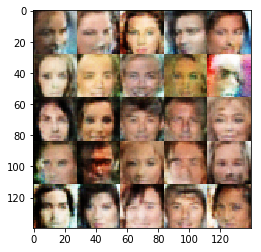

Epoch 1/1... Step: 4610... Discriminator Loss: 1.7389... Generator Loss: 0.2320
Epoch 1/1... Step: 4620... Discriminator Loss: 1.2089... Generator Loss: 0.5891
Epoch 1/1... Step: 4630... Discriminator Loss: 0.9398... Generator Loss: 0.8676
Epoch 1/1... Step: 4640... Discriminator Loss: 0.7346... Generator Loss: 0.8711
Epoch 1/1... Step: 4650... Discriminator Loss: 1.2229... Generator Loss: 0.4598
Epoch 1/1... Step: 4660... Discriminator Loss: 1.0144... Generator Loss: 0.7912
Epoch 1/1... Step: 4670... Discriminator Loss: 1.0312... Generator Loss: 1.2691
Epoch 1/1... Step: 4680... Discriminator Loss: 1.2222... Generator Loss: 0.4796
Epoch 1/1... Step: 4690... Discriminator Loss: 1.0046... Generator Loss: 0.5780
Epoch 1/1... Step: 4700... Discriminator Loss: 1.5532... Generator Loss: 0.2996
Cumulative Average Generator Loss / Discriminator Loss: 0.5741636753082275
Current Generator Loss / Discriminator Loss: 0.19285894930362701


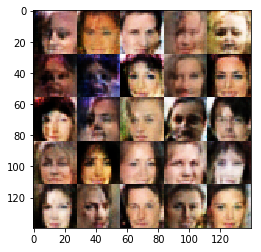

Epoch 1/1... Step: 4710... Discriminator Loss: 0.8768... Generator Loss: 1.2690
Epoch 1/1... Step: 4720... Discriminator Loss: 1.4193... Generator Loss: 0.3936
Epoch 1/1... Step: 4730... Discriminator Loss: 1.2476... Generator Loss: 0.5616
Epoch 1/1... Step: 4740... Discriminator Loss: 0.8203... Generator Loss: 1.0303
Epoch 1/1... Step: 4750... Discriminator Loss: 1.2822... Generator Loss: 0.4083
Epoch 1/1... Step: 4760... Discriminator Loss: 1.3014... Generator Loss: 0.5363
Epoch 1/1... Step: 4770... Discriminator Loss: 1.2989... Generator Loss: 0.4630
Epoch 1/1... Step: 4780... Discriminator Loss: 1.8991... Generator Loss: 0.1937
Epoch 1/1... Step: 4790... Discriminator Loss: 1.6420... Generator Loss: 0.2602
Epoch 1/1... Step: 4800... Discriminator Loss: 0.8112... Generator Loss: 1.0751
Cumulative Average Generator Loss / Discriminator Loss: 0.5724303126335144
Current Generator Loss / Discriminator Loss: 1.3252944946289062


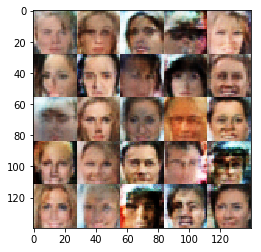

Epoch 1/1... Step: 4810... Discriminator Loss: 1.8897... Generator Loss: 0.2243
Epoch 1/1... Step: 4820... Discriminator Loss: 1.2712... Generator Loss: 0.4310
Epoch 1/1... Step: 4830... Discriminator Loss: 0.5436... Generator Loss: 1.5063
Epoch 1/1... Step: 4840... Discriminator Loss: 1.0592... Generator Loss: 0.6133
Epoch 1/1... Step: 4850... Discriminator Loss: 1.2874... Generator Loss: 0.5286
Epoch 1/1... Step: 4860... Discriminator Loss: 0.9631... Generator Loss: 0.7457
Epoch 1/1... Step: 4870... Discriminator Loss: 1.1071... Generator Loss: 0.6166
Epoch 1/1... Step: 4880... Discriminator Loss: 1.3143... Generator Loss: 0.3959
Epoch 1/1... Step: 4890... Discriminator Loss: 1.0063... Generator Loss: 0.7302
Epoch 1/1... Step: 4900... Discriminator Loss: 2.1090... Generator Loss: 0.1539
Cumulative Average Generator Loss / Discriminator Loss: 0.5704132914543152
Current Generator Loss / Discriminator Loss: 0.07295972108840942


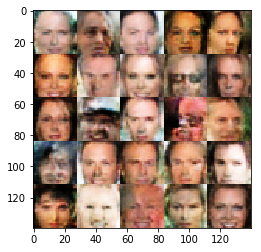

Epoch 1/1... Step: 4910... Discriminator Loss: 1.4658... Generator Loss: 0.3615
Epoch 1/1... Step: 4920... Discriminator Loss: 1.1286... Generator Loss: 0.5053
Epoch 1/1... Step: 4930... Discriminator Loss: 1.1461... Generator Loss: 0.7370
Epoch 1/1... Step: 4940... Discriminator Loss: 1.4909... Generator Loss: 0.3752
Epoch 1/1... Step: 4950... Discriminator Loss: 1.2509... Generator Loss: 0.4334
Epoch 1/1... Step: 4960... Discriminator Loss: 0.9784... Generator Loss: 1.1113
Epoch 1/1... Step: 4970... Discriminator Loss: 1.4262... Generator Loss: 0.4106
Epoch 1/1... Step: 4980... Discriminator Loss: 1.1069... Generator Loss: 0.5586
Epoch 1/1... Step: 4990... Discriminator Loss: 1.0492... Generator Loss: 0.6224
Epoch 1/1... Step: 5000... Discriminator Loss: 1.9468... Generator Loss: 0.1835
Cumulative Average Generator Loss / Discriminator Loss: 0.5670477151870728
Current Generator Loss / Discriminator Loss: 0.09423664957284927


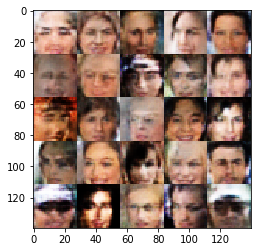

Epoch 1/1... Step: 5010... Discriminator Loss: 0.9304... Generator Loss: 1.0824
Epoch 1/1... Step: 5020... Discriminator Loss: 1.1007... Generator Loss: 0.6101
Epoch 1/1... Step: 5030... Discriminator Loss: 1.1780... Generator Loss: 0.6174
Epoch 1/1... Step: 5040... Discriminator Loss: 0.9737... Generator Loss: 0.7011
Epoch 1/1... Step: 5050... Discriminator Loss: 1.3805... Generator Loss: 0.3473
Epoch 1/1... Step: 5060... Discriminator Loss: 2.5356... Generator Loss: 0.1057
Epoch 1/1... Step: 5070... Discriminator Loss: 1.3367... Generator Loss: 0.4673
Epoch 1/1... Step: 5080... Discriminator Loss: 2.2633... Generator Loss: 0.1342
Epoch 1/1... Step: 5090... Discriminator Loss: 0.8538... Generator Loss: 1.3336
Epoch 1/1... Step: 5100... Discriminator Loss: 2.0839... Generator Loss: 0.1532
Cumulative Average Generator Loss / Discriminator Loss: 0.5627665519714355
Current Generator Loss / Discriminator Loss: 0.0735270157456398


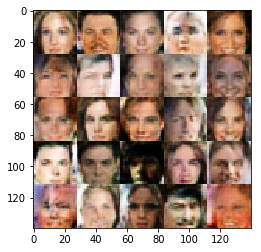

Epoch 1/1... Step: 5110... Discriminator Loss: 1.0143... Generator Loss: 0.9234
Epoch 1/1... Step: 5120... Discriminator Loss: 1.4699... Generator Loss: 0.4005
Epoch 1/1... Step: 5130... Discriminator Loss: 1.4590... Generator Loss: 0.3423
Epoch 1/1... Step: 5140... Discriminator Loss: 1.8764... Generator Loss: 0.2060
Epoch 1/1... Step: 5150... Discriminator Loss: 1.3442... Generator Loss: 0.4549
Epoch 1/1... Step: 5160... Discriminator Loss: 1.5648... Generator Loss: 0.2967
Epoch 1/1... Step: 5170... Discriminator Loss: 1.8035... Generator Loss: 0.2265
Epoch 1/1... Step: 5180... Discriminator Loss: 2.3506... Generator Loss: 0.1168
Epoch 1/1... Step: 5190... Discriminator Loss: 1.4335... Generator Loss: 0.3762
Epoch 1/1... Step: 5200... Discriminator Loss: 1.1846... Generator Loss: 0.4863
Cumulative Average Generator Loss / Discriminator Loss: 0.5553205013275146
Current Generator Loss / Discriminator Loss: 0.41056329011917114


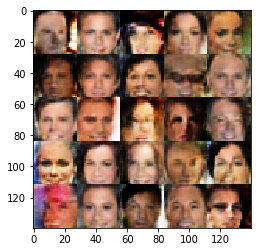

Epoch 1/1... Step: 5210... Discriminator Loss: 1.9948... Generator Loss: 0.1732
Epoch 1/1... Step: 5220... Discriminator Loss: 1.0829... Generator Loss: 0.5343
Epoch 1/1... Step: 5230... Discriminator Loss: 0.7482... Generator Loss: 1.0250
Epoch 1/1... Step: 5240... Discriminator Loss: 0.9099... Generator Loss: 1.4271
Epoch 1/1... Step: 5250... Discriminator Loss: 1.3918... Generator Loss: 0.3499
Epoch 1/1... Step: 5260... Discriminator Loss: 0.9490... Generator Loss: 0.6587
Epoch 1/1... Step: 5270... Discriminator Loss: 1.6531... Generator Loss: 0.2574
Epoch 1/1... Step: 5280... Discriminator Loss: 0.7645... Generator Loss: 0.8716
Epoch 1/1... Step: 5290... Discriminator Loss: 1.5391... Generator Loss: 0.3206
Epoch 1/1... Step: 5300... Discriminator Loss: 0.9187... Generator Loss: 0.8115
Cumulative Average Generator Loss / Discriminator Loss: 0.5550098419189453
Current Generator Loss / Discriminator Loss: 0.8833493590354919


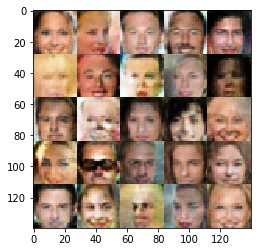

Epoch 1/1... Step: 5310... Discriminator Loss: 1.3547... Generator Loss: 0.4376
Epoch 1/1... Step: 5320... Discriminator Loss: 1.9465... Generator Loss: 0.1882
Epoch 1/1... Step: 5330... Discriminator Loss: 1.1853... Generator Loss: 0.5986
Epoch 1/1... Step: 5340... Discriminator Loss: 0.9998... Generator Loss: 0.6902
Epoch 1/1... Step: 5350... Discriminator Loss: 2.4850... Generator Loss: 0.1033
Epoch 1/1... Step: 5360... Discriminator Loss: 1.6770... Generator Loss: 0.2965
Epoch 1/1... Step: 5370... Discriminator Loss: 1.1838... Generator Loss: 0.5514
Epoch 1/1... Step: 5380... Discriminator Loss: 1.2569... Generator Loss: 1.9736
Epoch 1/1... Step: 5390... Discriminator Loss: 1.8526... Generator Loss: 0.2422
Epoch 1/1... Step: 5400... Discriminator Loss: 0.9462... Generator Loss: 0.7181
Cumulative Average Generator Loss / Discriminator Loss: 0.5514090061187744
Current Generator Loss / Discriminator Loss: 0.7589411735534668


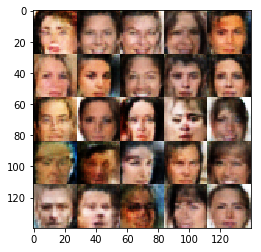

Epoch 1/1... Step: 5410... Discriminator Loss: 2.2643... Generator Loss: 0.1507
Epoch 1/1... Step: 5420... Discriminator Loss: 1.0368... Generator Loss: 0.6191
Epoch 1/1... Step: 5430... Discriminator Loss: 1.0612... Generator Loss: 0.6422
Epoch 1/1... Step: 5440... Discriminator Loss: 2.1641... Generator Loss: 0.1571
Epoch 1/1... Step: 5450... Discriminator Loss: 1.7791... Generator Loss: 0.2392
Epoch 1/1... Step: 5460... Discriminator Loss: 0.9306... Generator Loss: 0.6953
Epoch 1/1... Step: 5470... Discriminator Loss: 1.0230... Generator Loss: 0.7889
Epoch 1/1... Step: 5480... Discriminator Loss: 1.6350... Generator Loss: 0.2557
Epoch 1/1... Step: 5490... Discriminator Loss: 1.0597... Generator Loss: 0.7080
Epoch 1/1... Step: 5500... Discriminator Loss: 1.8482... Generator Loss: 0.2329
Cumulative Average Generator Loss / Discriminator Loss: 0.5461537837982178
Current Generator Loss / Discriminator Loss: 0.1260267198085785


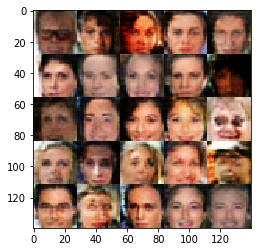

Epoch 1/1... Step: 5510... Discriminator Loss: 0.8166... Generator Loss: 0.8063
Epoch 1/1... Step: 5520... Discriminator Loss: 0.6467... Generator Loss: 1.7133
Epoch 1/1... Step: 5530... Discriminator Loss: 1.3505... Generator Loss: 0.4102
Epoch 1/1... Step: 5540... Discriminator Loss: 1.2089... Generator Loss: 0.5361
Epoch 1/1... Step: 5550... Discriminator Loss: 0.9525... Generator Loss: 0.8142
Epoch 1/1... Step: 5560... Discriminator Loss: 1.6288... Generator Loss: 0.2736
Epoch 1/1... Step: 5570... Discriminator Loss: 1.6004... Generator Loss: 0.3031
Epoch 1/1... Step: 5580... Discriminator Loss: 1.3782... Generator Loss: 0.3999
Epoch 1/1... Step: 5590... Discriminator Loss: 0.6589... Generator Loss: 0.9574
Epoch 1/1... Step: 5600... Discriminator Loss: 1.6249... Generator Loss: 0.3037
Cumulative Average Generator Loss / Discriminator Loss: 0.5462055802345276
Current Generator Loss / Discriminator Loss: 0.1868963986635208


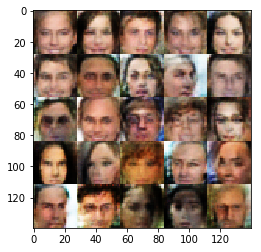

Epoch 1/1... Step: 5610... Discriminator Loss: 1.5857... Generator Loss: 0.3161
Epoch 1/1... Step: 5620... Discriminator Loss: 0.8368... Generator Loss: 1.0240
Epoch 1/1... Step: 5630... Discriminator Loss: 1.7889... Generator Loss: 0.2154
Epoch 1/1... Step: 5640... Discriminator Loss: 1.1457... Generator Loss: 0.7151
Epoch 1/1... Step: 5650... Discriminator Loss: 1.9566... Generator Loss: 0.2043
Epoch 1/1... Step: 5660... Discriminator Loss: 1.1517... Generator Loss: 1.2967
Epoch 1/1... Step: 5670... Discriminator Loss: 1.4149... Generator Loss: 0.4183
Epoch 1/1... Step: 5680... Discriminator Loss: 1.7457... Generator Loss: 0.2577
Epoch 1/1... Step: 5690... Discriminator Loss: 1.7843... Generator Loss: 0.2471
Epoch 1/1... Step: 5700... Discriminator Loss: 0.9087... Generator Loss: 0.7666
Cumulative Average Generator Loss / Discriminator Loss: 0.5429509878158569
Current Generator Loss / Discriminator Loss: 0.8436000943183899


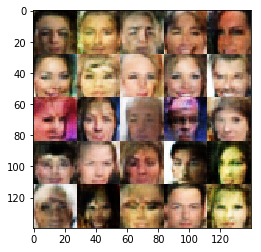

Epoch 1/1... Step: 5710... Discriminator Loss: 1.6662... Generator Loss: 0.2564
Epoch 1/1... Step: 5720... Discriminator Loss: 1.6607... Generator Loss: 0.2415
Epoch 1/1... Step: 5730... Discriminator Loss: 1.5181... Generator Loss: 0.3283
Epoch 1/1... Step: 5740... Discriminator Loss: 1.1584... Generator Loss: 0.5928
Epoch 1/1... Step: 5750... Discriminator Loss: 1.7039... Generator Loss: 0.2618
Epoch 1/1... Step: 5760... Discriminator Loss: 1.1557... Generator Loss: 0.5457
Epoch 1/1... Step: 5770... Discriminator Loss: 0.7962... Generator Loss: 0.8920
Epoch 1/1... Step: 5780... Discriminator Loss: 1.5533... Generator Loss: 0.2872
Epoch 1/1... Step: 5790... Discriminator Loss: 1.7361... Generator Loss: 0.2361
Epoch 1/1... Step: 5800... Discriminator Loss: 1.6565... Generator Loss: 0.2742
Cumulative Average Generator Loss / Discriminator Loss: 0.5375243425369263
Current Generator Loss / Discriminator Loss: 0.16552962362766266


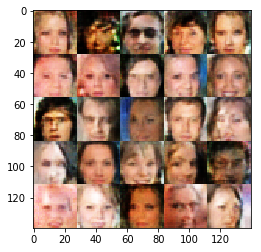

Epoch 1/1... Step: 5810... Discriminator Loss: 1.1450... Generator Loss: 0.6038
Epoch 1/1... Step: 5820... Discriminator Loss: 0.9766... Generator Loss: 0.8594
Epoch 1/1... Step: 5830... Discriminator Loss: 0.6934... Generator Loss: 0.9979
Epoch 1/1... Step: 5840... Discriminator Loss: 2.1821... Generator Loss: 0.1497
Epoch 1/1... Step: 5850... Discriminator Loss: 2.1410... Generator Loss: 0.1537
Epoch 1/1... Step: 5860... Discriminator Loss: 1.5744... Generator Loss: 0.3333
Epoch 1/1... Step: 5870... Discriminator Loss: 1.2517... Generator Loss: 0.5164
Epoch 1/1... Step: 5880... Discriminator Loss: 1.8034... Generator Loss: 0.2157
Epoch 1/1... Step: 5890... Discriminator Loss: 1.8728... Generator Loss: 0.2164
Epoch 1/1... Step: 5900... Discriminator Loss: 0.9491... Generator Loss: 0.6919
Cumulative Average Generator Loss / Discriminator Loss: 0.5334094166755676
Current Generator Loss / Discriminator Loss: 0.7289759516716003


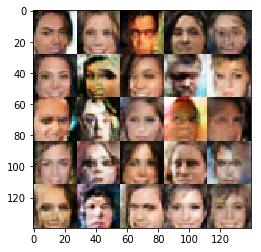

Epoch 1/1... Step: 5910... Discriminator Loss: 0.8127... Generator Loss: 1.0061
Epoch 1/1... Step: 5920... Discriminator Loss: 1.7025... Generator Loss: 0.2665
Epoch 1/1... Step: 5930... Discriminator Loss: 1.8252... Generator Loss: 0.2052
Epoch 1/1... Step: 5940... Discriminator Loss: 0.8592... Generator Loss: 1.3468
Epoch 1/1... Step: 5950... Discriminator Loss: 0.7884... Generator Loss: 1.6950
Epoch 1/1... Step: 5960... Discriminator Loss: 1.5367... Generator Loss: 0.2962
Epoch 1/1... Step: 5970... Discriminator Loss: 1.8455... Generator Loss: 0.2126
Epoch 1/1... Step: 5980... Discriminator Loss: 1.8461... Generator Loss: 0.2204
Epoch 1/1... Step: 5990... Discriminator Loss: 1.9701... Generator Loss: 0.2106
Epoch 1/1... Step: 6000... Discriminator Loss: 1.4236... Generator Loss: 0.3433
Cumulative Average Generator Loss / Discriminator Loss: 0.530820906162262
Current Generator Loss / Discriminator Loss: 0.24117958545684814


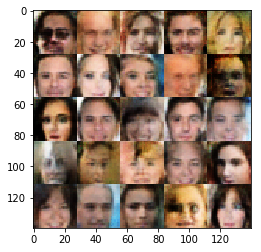

Epoch 1/1... Step: 6010... Discriminator Loss: 1.6339... Generator Loss: 2.1347
Epoch 1/1... Step: 6020... Discriminator Loss: 0.6795... Generator Loss: 0.9666
Epoch 1/1... Step: 6030... Discriminator Loss: 1.5269... Generator Loss: 0.3101
Epoch 1/1... Step: 6040... Discriminator Loss: 1.2991... Generator Loss: 0.4602
Epoch 1/1... Step: 6050... Discriminator Loss: 1.8302... Generator Loss: 0.2219
Epoch 1/1... Step: 6060... Discriminator Loss: 1.9177... Generator Loss: 0.1944
Epoch 1/1... Step: 6070... Discriminator Loss: 2.4573... Generator Loss: 0.1143
Epoch 1/1... Step: 6080... Discriminator Loss: 0.8489... Generator Loss: 1.3739
Epoch 1/1... Step: 6090... Discriminator Loss: 2.6817... Generator Loss: 0.0832
Epoch 1/1... Step: 6100... Discriminator Loss: 1.1405... Generator Loss: 1.2371
Cumulative Average Generator Loss / Discriminator Loss: 0.5290308594703674
Current Generator Loss / Discriminator Loss: 1.0847313404083252


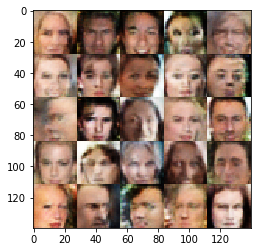

Epoch 1/1... Step: 6110... Discriminator Loss: 1.1700... Generator Loss: 0.5875
Epoch 1/1... Step: 6120... Discriminator Loss: 1.7441... Generator Loss: 0.2775
Epoch 1/1... Step: 6130... Discriminator Loss: 0.9289... Generator Loss: 0.6885
Epoch 1/1... Step: 6140... Discriminator Loss: 0.9370... Generator Loss: 0.6870
Epoch 1/1... Step: 6150... Discriminator Loss: 1.0917... Generator Loss: 1.9122
Epoch 1/1... Step: 6160... Discriminator Loss: 1.5489... Generator Loss: 0.2956
Epoch 1/1... Step: 6170... Discriminator Loss: 1.1819... Generator Loss: 0.5300
Epoch 1/1... Step: 6180... Discriminator Loss: 1.5275... Generator Loss: 0.4335
Epoch 1/1... Step: 6190... Discriminator Loss: 1.0858... Generator Loss: 0.5293
Epoch 1/1... Step: 6200... Discriminator Loss: 2.1495... Generator Loss: 0.1576
Cumulative Average Generator Loss / Discriminator Loss: 0.5278134942054749
Current Generator Loss / Discriminator Loss: 0.07333239167928696


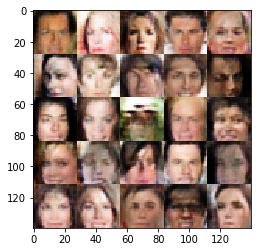

Epoch 1/1... Step: 6210... Discriminator Loss: 0.8842... Generator Loss: 0.9833
Epoch 1/1... Step: 6220... Discriminator Loss: 1.2273... Generator Loss: 0.4635
Epoch 1/1... Step: 6230... Discriminator Loss: 1.9238... Generator Loss: 0.2069
Epoch 1/1... Step: 6240... Discriminator Loss: 1.3212... Generator Loss: 0.4383
Epoch 1/1... Step: 6250... Discriminator Loss: 1.1951... Generator Loss: 0.4715
Epoch 1/1... Step: 6260... Discriminator Loss: 1.9305... Generator Loss: 0.2005
Epoch 1/1... Step: 6270... Discriminator Loss: 1.0535... Generator Loss: 0.6060
Epoch 1/1... Step: 6280... Discriminator Loss: 1.0436... Generator Loss: 0.6293
Epoch 1/1... Step: 6290... Discriminator Loss: 0.9021... Generator Loss: 0.9844
Epoch 1/1... Step: 6300... Discriminator Loss: 0.8110... Generator Loss: 0.9324
Cumulative Average Generator Loss / Discriminator Loss: 0.5271080732345581
Current Generator Loss / Discriminator Loss: 1.1497732400894165


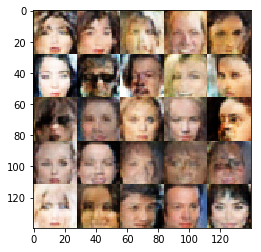

Epoch 1/1... Step: 6310... Discriminator Loss: 1.4503... Generator Loss: 0.3145
Epoch 1/1... Step: 6320... Discriminator Loss: 0.9561... Generator Loss: 0.8314
Epoch 1/1... Step: 6330... Discriminator Loss: 1.6857... Generator Loss: 0.2684


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
alpha = 0.1
beta1 = 0.2
dropout = 0.2

epochs = 1

celeba_dataset = Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

ganTrainer = GANTrainer()

with tf.Graph().as_default():
    ganTrainer.train_gan(epochs, batch_size, 
                         z_dim, learning_rate, 
                         alpha, beta1, dropout,
                         celeba_dataset.get_batches,
                         celeba_dataset.shape, 
                         celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.